**Note, after training each model, execute Save at the end**

# Init

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%env DRIVE_DATA_DIR=./gdrive/MyDrive/master-thesis
%env COLAB_DATA_DIR=data

env: DRIVE_DATA_DIR=./gdrive/MyDrive/master-thesis
env: COLAB_DATA_DIR=data


In [ ]:
import numpy as np
import keras
from keras import layers, initializers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pickle

import seaborn as sn
import pandas as pd
from tensorflow import concat, argmax

import os
import tensorflow as tf
from itertools import cycle

# Configuration

In [ ]:
%env IMAGE_FORMAT=png

env: IMAGE_FORMAT=png


In [ ]:
batch_size = 32 # (TSAI VGG19)

In [ ]:
epoch_counts = [10, 10]

In [ ]:
phase1optimizer="RMSprop"
phase2optimizer="RMSprop"

def phase_1_optimizer():
  return keras.optimizers.RMSprop()

def phase_2_optimizer():
  return keras.optimizers.RMSprop(1e-5)

Train / Validation / Test split = 70 / 15 / 15

*Tsai2021*

In [ ]:
seed=123

## Kather16

In [ ]:
%env DATASET=Kather_texture_2016_image_tiles_5000

env: DATASET=Kather_texture_2016_image_tiles_5000


In [ ]:
image_size=(150, 150)

## Kather16 NORMALIZED

In [ ]:
%env DATASET=Kather_texture_2016_image_tiles_5000_NORM

env: DATASET=Kather_texture_2016_image_tiles_5000_NORM


In [ ]:
image_size=(150, 150)

## Kather19

In [ ]:
%env DATASET=NCT-CRC-HE-100K

env: DATASET=NCT-CRC-HE-100K


In [ ]:
image_size=(224, 224)

## Merged datasets - k16 NONORM

In [ ]:
%env DATASET=merged_datasets_k16-NONORM

env: DATASET=merged_datasets


In [ ]:
image_size=(100, 100)

## Merged datasets - k16 NORM

In [ ]:
%env DATASET=merged_datasets_k16-NORM

env: DATASET=merged_datasets_k16-NORM


In [ ]:
image_size=(100, 100)

# Loading images from drive

In [ ]:
%%shell

mkdir $COLAB_DATA_DIR
cp $DRIVE_DATA_DIR/$DATASET.${IMAGE_FORMAT}.zip $COLAB_DATA_DIR
unzip $COLAB_DATA_DIR/$DATASET.${IMAGE_FORMAT}.zip -d . && rm $COLAB_DATA_DIR/$DATASET.${IMAGE_FORMAT}.zip

In [ ]:
dataset=os.environ['COLAB_DATA_DIR']+"/merged_datasets/"

In [ ]:
train_ds, validation_ds = keras.utils.image_dataset_from_directory(
    dataset,
    labels="inferred",
    label_mode="int",
    # class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=seed,
    validation_split=0.3, # 0.9
    subset="both",
    crop_to_aspect_ratio=False
)

Found 110930 files belonging to 9 classes.
Using 77651 files for training.
Using 33279 files for validation.


In [ ]:
val_batches = validation_ds.cardinality().numpy()         # 70 %
test_ds = validation_ds.take(( 1 * val_batches) // 2) # 7*val_batches) // 8)        # 15 %
validation_ds = validation_ds.skip(( 1 * val_batches) // 2) # 7*val_batches) // 8)  # 15 %

# https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cardinality
# https://stackoverflow.com/a/74609848/12108610

In [ ]:
# number of files / batch size
print(f"Number of training samples: {train_ds.cardinality().numpy() * batch_size}")
print(f"Number of validation samples: {validation_ds.cardinality().numpy() * batch_size}")
print(f"Number of test samples: {test_ds.cardinality().numpy() * batch_size}")

Number of training samples: 77664
Number of validation samples: 16640
Number of test samples: 16640


In [ ]:
class_names = train_ds.class_names
class_names

['ADIPOSE',
 'BACK',
 'DEBRIS',
 'LYMPHO',
 'MUCOSA',
 'MUS',
 'NORM',
 'STROMA',
 'TUMOR']

In [ ]:
number_of_classes = len(class_names)

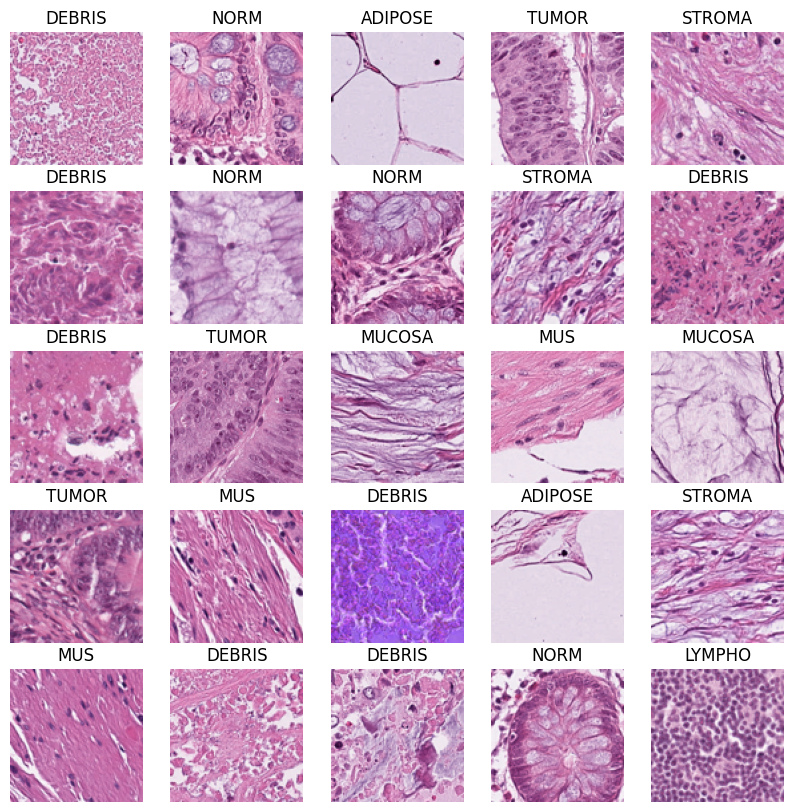

In [ ]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Training Kather16

## VGG19

In [ ]:
model_name = "VGG19"

In [ ]:
base_model = keras.applications.VGG19(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(image_size[0], image_size[1], 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.


80134624/80134624 [==============================] - 4s 0us/step


In [ ]:
# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(image_size[0], image_size[1], 3))


# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(8, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 150, 150, 3)       0         Y          
                                                                            
 vgg19 (Functional)          (None, 4, 4, 512)         2002438   N          
                                                       4                    
                                                                            
 global_average_pooling2d (  (None, 512)               0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dropout (Dropout)           (None, 512)               0     

In [ ]:
model.compile(
    optimizer=phase_1_optimizer(),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

print("Fitting the top layer of the model")
model.fit(train_ds, epochs=epoch_counts[0], validation_data=validation_ds)


Fitting the top layer of the model
Epoch 1/10
110/110 [==============================] - 23s 147ms/step - loss: 1.4693 - accuracy: 0.5223 - val_loss: 1.0219 - val_accuracy: 0.7500
Epoch 2/10
110/110 [==============================] - 11s 100ms/step - loss: 0.9255 - accuracy: 0.7186 - val_loss: 0.7753 - val_accuracy: 0.7945
Epoch 3/10
110/110 [==============================] - 13s 115ms/step - loss: 0.7522 - accuracy: 0.7751 - val_loss: 0.6763 - val_accuracy: 0.8037
Epoch 4/10
110/110 [==============================] - 12s 104ms/step - loss: 0.6714 - accuracy: 0.7980 - val_loss: 0.6201 - val_accuracy: 0.8089
Epoch 5/10
110/110 [==============================] - 12s 107ms/step - loss: 0.6187 - accuracy: 0.8051 - val_loss: 0.5835 - val_accuracy: 0.8089
Epoch 6/10
110/110 [==============================] - 12s 109ms/step - loss: 0.5838 - accuracy: 0.8117 - val_loss: 0.5505 - val_accuracy: 0.8298
Epoch 7/10
110/110 [==============================] - 13s 107ms/step - loss: 0.5541 - accuracy:

In [ ]:
accuracy_phase_1 = model.history.history["accuracy"]
val_accuracy_phase_1 = model.history.history["val_accuracy"]

In [ ]:
loss_phase_1 = model.history.history["loss"]
val_loss_phase_1 = model.history.history["val_loss"]

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=phase_2_optimizer(),  # Low learning rate
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

print("Fitting the end-to-end model")
model.fit(train_ds, epochs=epoch_counts[1], validation_data=validation_ds)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 150, 150, 3)       0         Y          
                                                                            
 vgg19 (Functional)          (None, 4, 4, 512)         2002438   Y          
                                                       4                    
                                                                            
 global_average_pooling2d (  (None, 512)               0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dropout (Dropout)           (None, 512)               0     

### Accuracy

In [ ]:
accuracy_phase_2 = model.history.history["accuracy"]
val_accuracy_phase_2 = model.history.history["val_accuracy"]

In [ ]:
loss_phase_2 = model.history.history["loss"]
val_loss_phase_2 = model.history.history["val_loss"]

In [ ]:
print("Test dataset evaluation")
model.evaluate(test_ds)

Test dataset evaluation
23/23 [==============================] - 2s 83ms/step - loss: 0.2745 - accuracy: 0.9293


[0.2744981050491333, 0.929347813129425]

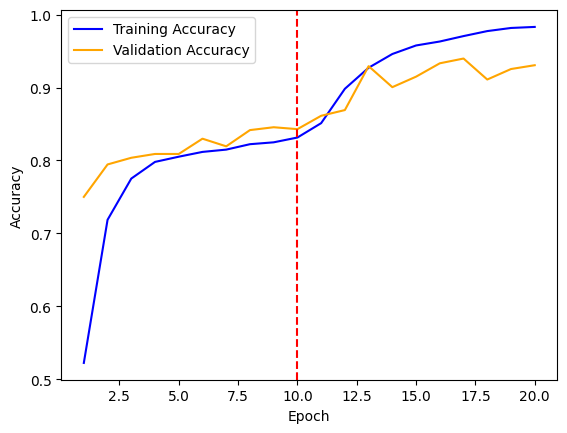

In [ ]:
# Visualize loss history
plt.plot(range(1, sum(epoch_counts) + 1), accuracy_phase_1+accuracy_phase_2, color='blue')
plt.plot(range(1, sum(epoch_counts) + 1), val_accuracy_phase_1+val_accuracy_phase_2, color='orange')
plt.axvline(x=epoch_counts[0], color='r', linestyle='--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

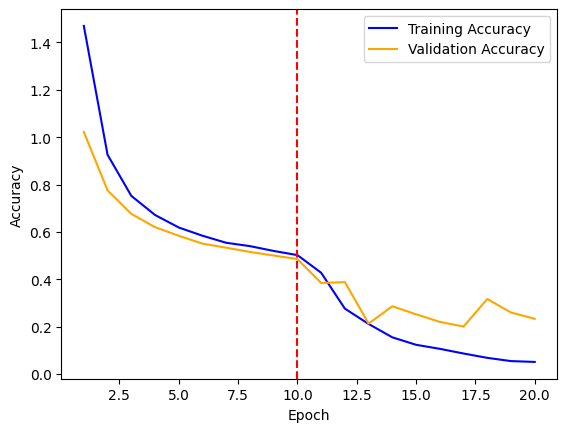

In [ ]:
# Visualize loss history
plt.plot(range(1, sum(epoch_counts) + 1), loss_phase_1+loss_phase_2, color='blue')
plt.plot(range(1, sum(epoch_counts) + 1), val_loss_phase_1+val_loss_phase_2, color='orange')
plt.axvline(x=epoch_counts[0], color='r', linestyle='--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

## EfficientNetV2B0

In [ ]:
model_name = "EfficientNetV2B0"

In [ ]:
base_model = keras.applications.EfficientNetV2B0(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(image_size[0], image_size[1], 3),
    include_top=False,
    include_preprocessing=False,
)  # Do not include the ImageNet classifier at the top.

24274472/24274472 [==============================] - 2s 0us/step


In [ ]:
# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(image_size[0], image_size[1], 3))


# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(8, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 150, 150, 3)       0         Y          
                                                                            
 efficientnetv2-b0 (Functio  (None, 5, 5, 1280)        5919312   N          
 nal)                                                                       
                                                                            
 global_average_pooling2d (  (None, 1280)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dropout (Dropout)           (None, 1280)              0     

In [ ]:
model.compile(
    optimizer=phase_1_optimizer(),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

print("Fitting the top layer of the model")
model.fit(train_ds, epochs=epoch_counts[0], validation_data=validation_ds)


Fitting the top layer of the model
Epoch 1/10
110/110 [==============================] - 27s 109ms/step - loss: 0.8416 - accuracy: 0.7509 - val_loss: 0.5305 - val_accuracy: 0.8521
Epoch 2/10
110/110 [==============================] - 7s 62ms/step - loss: 0.4503 - accuracy: 0.8571 - val_loss: 0.3990 - val_accuracy: 0.8757
Epoch 3/10
110/110 [==============================] - 8s 68ms/step - loss: 0.3565 - accuracy: 0.8829 - val_loss: 0.3502 - val_accuracy: 0.8809
Epoch 4/10
110/110 [==============================] - 6s 48ms/step - loss: 0.3151 - accuracy: 0.8943 - val_loss: 0.3270 - val_accuracy: 0.8874
Epoch 5/10
110/110 [==============================] - 7s 62ms/step - loss: 0.2890 - accuracy: 0.9066 - val_loss: 0.3218 - val_accuracy: 0.8861
Epoch 6/10
110/110 [==============================] - 5s 48ms/step - loss: 0.2654 - accuracy: 0.9106 - val_loss: 0.2942 - val_accuracy: 0.8992
Epoch 7/10
110/110 [==============================] - 8s 66ms/step - loss: 0.2437 - accuracy: 0.9186 - va

In [ ]:
accuracy_phase_1 = model.history.history["accuracy"]
val_accuracy_phase_1 = model.history.history["val_accuracy"]

In [ ]:
loss_phase_1 = model.history.history["loss"]
val_loss_phase_1 = model.history.history["val_loss"]

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=phase_2_optimizer(),  # Low learning rate
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

print("Fitting the end-to-end model")
model.fit(train_ds, epochs=epoch_counts[1], validation_data=validation_ds)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 150, 150, 3)       0         Y          
                                                                            
 efficientnetv2-b0 (Functio  (None, 5, 5, 1280)        5919312   Y          
 nal)                                                                       
                                                                            
 global_average_pooling2d (  (None, 1280)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dropout (Dropout)           (None, 1280)              0     

### Accuracy

In [ ]:
accuracy_phase_2 = model.history.history["accuracy"]
val_accuracy_phase_2 = model.history.history["val_accuracy"]

In [ ]:
loss_phase_2 = model.history.history["loss"]
val_loss_phase_2 = model.history.history["val_loss"]

In [ ]:
print("Test dataset evaluation")
model.evaluate(test_ds)

Test dataset evaluation
23/23 [==============================] - 2s 69ms/step - loss: 0.1865 - accuracy: 0.9361


[0.18645311892032623, 0.936141312122345]

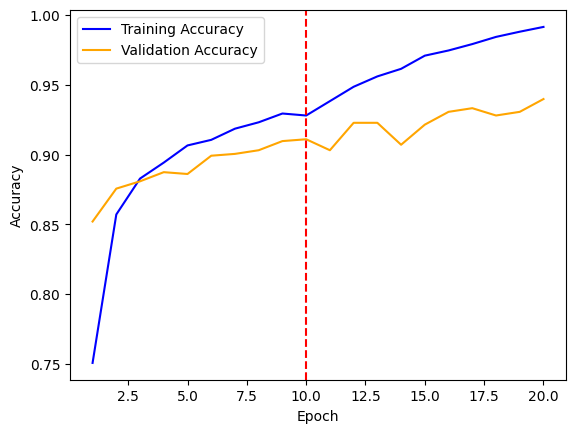

In [ ]:
# Visualize loss history
plt.plot(range(1, sum(epoch_counts) + 1), accuracy_phase_1+accuracy_phase_2, color='blue')
plt.plot(range(1, sum(epoch_counts) + 1), val_accuracy_phase_1+val_accuracy_phase_2, color='orange')
plt.axvline(x=epoch_counts[0], color='r', linestyle='--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

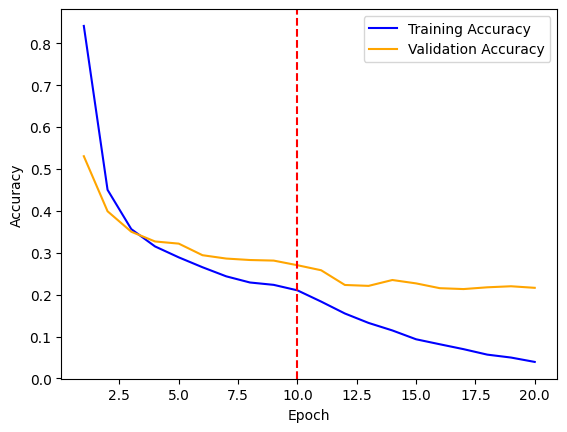

In [ ]:
# Visualize loss history
plt.plot(range(1, sum(epoch_counts) + 1), loss_phase_1+loss_phase_2, color='blue')
plt.plot(range(1, sum(epoch_counts) + 1), val_loss_phase_1+val_loss_phase_2, color='orange')
plt.axvline(x=epoch_counts[0], color='r', linestyle='--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

## MobileNetV2

In [ ]:
model_name = "MobileNetV2"

In [ ]:
base_model = keras.applications.MobileNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(image_size[0], image_size[1], 3),
    include_top=False,
    alpha=1.0
)  # Do not include the ImageNet classifier at the top.

In [ ]:
# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(image_size[0], image_size[1], 3))


# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(8, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "model_2"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling_2 (Rescaling)     (None, 150, 150, 3)       0         Y          
                                                                            
 mobilenetv2_1.00_224 (Func  (None, 5, 5, 1280)        2257984   N          
 tional)                                                                    
                                                                            
 global_average_pooling2d_2  (None, 1280)              0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dropout_2 (Dropout)         (None, 1280)              0   

In [ ]:
model.compile(
    optimizer=phase_1_optimizer(),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

print("Fitting the top layer of the model")
model.fit(train_ds, epochs=epoch_counts[0], validation_data=validation_ds)


Fitting the top layer of the model
Epoch 1/10
110/110 [==============================] - 9s 62ms/step - loss: 0.8720 - accuracy: 0.7023 - val_loss: 0.5404 - val_accuracy: 0.8272
Epoch 2/10
110/110 [==============================] - 5s 43ms/step - loss: 0.4641 - accuracy: 0.8309 - val_loss: 0.4118 - val_accuracy: 0.8678
Epoch 3/10
110/110 [==============================] - 5s 43ms/step - loss: 0.3740 - accuracy: 0.8654 - val_loss: 0.4103 - val_accuracy: 0.8599
Epoch 4/10
110/110 [==============================] - 6s 57ms/step - loss: 0.3134 - accuracy: 0.8891 - val_loss: 0.3970 - val_accuracy: 0.8626
Epoch 5/10
110/110 [==============================] - 5s 42ms/step - loss: 0.2775 - accuracy: 0.9009 - val_loss: 0.3991 - val_accuracy: 0.8586
Epoch 6/10
110/110 [==============================] - 6s 55ms/step - loss: 0.2484 - accuracy: 0.9111 - val_loss: 0.3583 - val_accuracy: 0.8835
Epoch 7/10
110/110 [==============================] - 5s 44ms/step - loss: 0.2402 - accuracy: 0.9169 - val_

In [ ]:
accuracy_phase_1 = model.history.history["accuracy"]
val_accuracy_phase_1 = model.history.history["val_accuracy"]

In [ ]:
loss_phase_1 = model.history.history["loss"]
val_loss_phase_1 = model.history.history["val_loss"]

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=phase_2_optimizer(),  # Low learning rate
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

print("Fitting the end-to-end model")
model.fit(train_ds, epochs=epoch_counts[1], validation_data=validation_ds)

Model: "model_2"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling_2 (Rescaling)     (None, 150, 150, 3)       0         Y          
                                                                            
 mobilenetv2_1.00_224 (Func  (None, 5, 5, 1280)        2257984   Y          
 tional)                                                                    
                                                                            
 global_average_pooling2d_2  (None, 1280)              0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dropout_2 (Dropout)         (None, 1280)              0   

### Accuracy

In [ ]:
accuracy_phase_2 = model.history.history["accuracy"]
val_accuracy_phase_2 = model.history.history["val_accuracy"]

In [ ]:
loss_phase_2 = model.history.history["loss"]
val_loss_phase_2 = model.history.history["val_loss"]

In [ ]:
print("Test dataset evaluation")
model.evaluate(test_ds)

Test dataset evaluation
23/23 [==============================] - 1s 55ms/step - loss: 0.2918 - accuracy: 0.9266


[0.29181668162345886, 0.926630437374115]

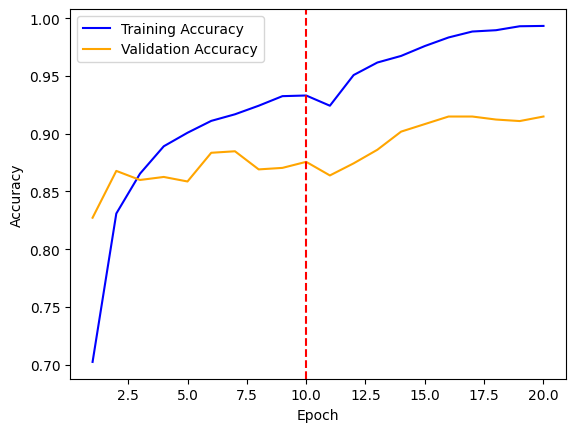

In [ ]:
# Visualize loss history
plt.plot(range(1, sum(epoch_counts) + 1), accuracy_phase_1+accuracy_phase_2, color='blue')
plt.plot(range(1, sum(epoch_counts) + 1), val_accuracy_phase_1+val_accuracy_phase_2, color='orange')
plt.axvline(x=epoch_counts[0], color='r', linestyle='--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

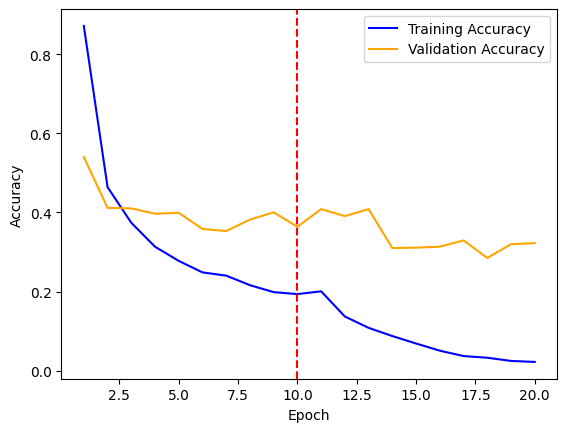

In [ ]:
# Visualize loss history
plt.plot(range(1, sum(epoch_counts) + 1), loss_phase_1+loss_phase_2, color='blue')
plt.plot(range(1, sum(epoch_counts) + 1), val_loss_phase_1+val_loss_phase_2, color='orange')
plt.axvline(x=epoch_counts[0], color='r', linestyle='--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

# Training Kather16 NORMALIZED

## VGG19

In [ ]:
model_name = "VGG19"

In [ ]:
base_model = keras.applications.VGG19(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(image_size[0], image_size[1], 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.


In [ ]:
# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(image_size[0], image_size[1], 3))


# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(8, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "model_2"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling_2 (Rescaling)     (None, 150, 150, 3)       0         Y          
                                                                            
 vgg19 (Functional)          (None, 4, 4, 512)         2002438   N          
                                                       4                    
                                                                            
 global_average_pooling2d_2  (None, 512)               0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dropout_2 (Dropout)         (None, 512)               0   

In [ ]:
model.compile(
    optimizer=phase_1_optimizer(),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

print("Fitting the top layer of the model")
model.fit(train_ds, epochs=epoch_counts[0], validation_data=validation_ds)


Fitting the top layer of the model
Epoch 1/10
110/110 [==============================] - 13s 113ms/step - loss: 1.5590 - accuracy: 0.4969 - val_loss: 1.1312 - val_accuracy: 0.7173
Epoch 2/10
110/110 [==============================] - 13s 113ms/step - loss: 0.9996 - accuracy: 0.7129 - val_loss: 0.8667 - val_accuracy: 0.7683
Epoch 3/10
110/110 [==============================] - 13s 114ms/step - loss: 0.8184 - accuracy: 0.7429 - val_loss: 0.7544 - val_accuracy: 0.7880
Epoch 4/10
110/110 [==============================] - 13s 112ms/step - loss: 0.7298 - accuracy: 0.7700 - val_loss: 0.6991 - val_accuracy: 0.7893
Epoch 5/10
110/110 [==============================] - 12s 112ms/step - loss: 0.6884 - accuracy: 0.7723 - val_loss: 0.6561 - val_accuracy: 0.8128
Epoch 6/10
110/110 [==============================] - 12s 105ms/step - loss: 0.6519 - accuracy: 0.7823 - val_loss: 0.6280 - val_accuracy: 0.8181
Epoch 7/10
110/110 [==============================] - 12s 108ms/step - loss: 0.6270 - accuracy:

In [ ]:
accuracy_phase_1 = model.history.history["accuracy"]
val_accuracy_phase_1 = model.history.history["val_accuracy"]

In [ ]:
loss_phase_1 = model.history.history["loss"]
val_loss_phase_1 = model.history.history["val_loss"]

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=phase_2_optimizer(),  # Low learning rate
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

print("Fitting the end-to-end model")
model.fit(train_ds, epochs=epoch_counts[1], validation_data=validation_ds)

Model: "model_2"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling_2 (Rescaling)     (None, 150, 150, 3)       0         Y          
                                                                            
 vgg19 (Functional)          (None, 4, 4, 512)         2002438   Y          
                                                       4                    
                                                                            
 global_average_pooling2d_2  (None, 512)               0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dropout_2 (Dropout)         (None, 512)               0   

### Accuracy

In [ ]:
accuracy_phase_2 = model.history.history["accuracy"]
val_accuracy_phase_2 = model.history.history["val_accuracy"]

In [ ]:
loss_phase_2 = model.history.history["loss"]
val_loss_phase_2 = model.history.history["val_loss"]

In [ ]:
print("Test dataset evaluation")
model.evaluate(test_ds)

Test dataset evaluation
23/23 [==============================] - 2s 84ms/step - loss: 0.3642 - accuracy: 0.9117


[0.3641946315765381, 0.9116848111152649]

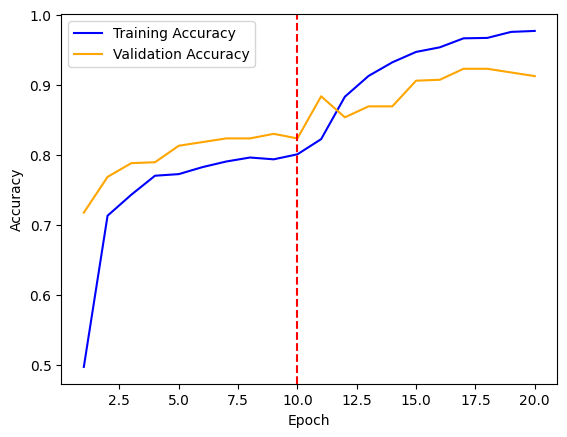

In [ ]:
# Visualize loss history
plt.plot(range(1, sum(epoch_counts) + 1), accuracy_phase_1+accuracy_phase_2, color='blue')
plt.plot(range(1, sum(epoch_counts) + 1), val_accuracy_phase_1+val_accuracy_phase_2, color='orange')
plt.axvline(x=epoch_counts[0], color='r', linestyle='--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

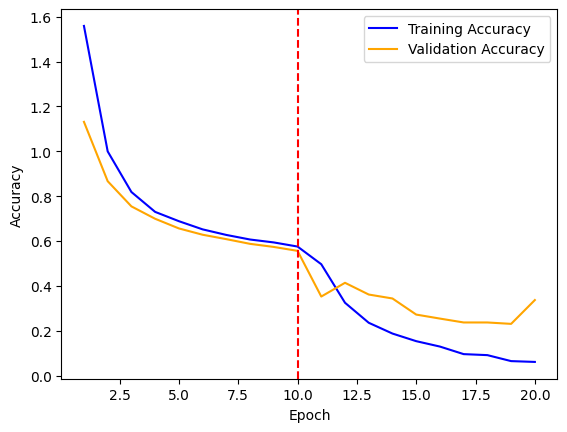

In [ ]:
# Visualize loss history
plt.plot(range(1, sum(epoch_counts) + 1), loss_phase_1+loss_phase_2, color='blue')
plt.plot(range(1, sum(epoch_counts) + 1), val_loss_phase_1+val_loss_phase_2, color='orange')
plt.axvline(x=epoch_counts[0], color='r', linestyle='--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

## EfficientNetV2B0

In [ ]:
model_name = "EfficientNetV2B0"

In [ ]:
base_model = keras.applications.EfficientNetV2B0(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(image_size[0], image_size[1], 3),
    include_top=False,
    include_preprocessing=False,
)  # Do not include the ImageNet classifier at the top.

In [ ]:
# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(image_size[0], image_size[1], 3))


# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(8, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "model_3"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_8 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling_3 (Rescaling)     (None, 150, 150, 3)       0         Y          
                                                                            
 efficientnetv2-b0 (Functio  (None, 5, 5, 1280)        5919312   N          
 nal)                                                                       
                                                                            
 global_average_pooling2d_3  (None, 1280)              0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dropout_3 (Dropout)         (None, 1280)              0   

In [ ]:
model.compile(
    optimizer=phase_1_optimizer(),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

print("Fitting the top layer of the model")
model.fit(train_ds, epochs=epoch_counts[0], validation_data=validation_ds)


Fitting the top layer of the model
Epoch 1/10
110/110 [==============================] - 15s 73ms/step - loss: 0.9632 - accuracy: 0.6991 - val_loss: 0.6379 - val_accuracy: 0.8220
Epoch 2/10
110/110 [==============================] - 7s 60ms/step - loss: 0.5456 - accuracy: 0.8237 - val_loss: 0.4906 - val_accuracy: 0.8534
Epoch 3/10
110/110 [==============================] - 7s 58ms/step - loss: 0.4528 - accuracy: 0.8503 - val_loss: 0.4469 - val_accuracy: 0.8521
Epoch 4/10
110/110 [==============================] - 5s 46ms/step - loss: 0.3988 - accuracy: 0.8654 - val_loss: 0.4043 - val_accuracy: 0.8822
Epoch 5/10
110/110 [==============================] - 5s 47ms/step - loss: 0.3660 - accuracy: 0.8797 - val_loss: 0.3816 - val_accuracy: 0.8783
Epoch 6/10
110/110 [==============================] - 5s 46ms/step - loss: 0.3366 - accuracy: 0.8889 - val_loss: 0.3797 - val_accuracy: 0.8835
Epoch 7/10
110/110 [==============================] - 7s 65ms/step - loss: 0.3151 - accuracy: 0.8906 - val

In [ ]:
accuracy_phase_1 = model.history.history["accuracy"]
val_accuracy_phase_1 = model.history.history["val_accuracy"]

In [ ]:
loss_phase_1 = model.history.history["loss"]
val_loss_phase_1 = model.history.history["val_loss"]

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=phase_2_optimizer(),  # Low learning rate
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

print("Fitting the end-to-end model")
model.fit(train_ds, epochs=epoch_counts[1], validation_data=validation_ds)

Model: "model_3"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_8 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling_3 (Rescaling)     (None, 150, 150, 3)       0         Y          
                                                                            
 efficientnetv2-b0 (Functio  (None, 5, 5, 1280)        5919312   Y          
 nal)                                                                       
                                                                            
 global_average_pooling2d_3  (None, 1280)              0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dropout_3 (Dropout)         (None, 1280)              0   

### Accuracy

In [ ]:
accuracy_phase_2 = model.history.history["accuracy"]
val_accuracy_phase_2 = model.history.history["val_accuracy"]

In [ ]:
loss_phase_2 = model.history.history["loss"]
val_loss_phase_2 = model.history.history["val_loss"]

In [ ]:
print("Test dataset evaluation")
model.evaluate(test_ds)

Test dataset evaluation
23/23 [==============================] - 1s 34ms/step - loss: 0.2551 - accuracy: 0.9253


[0.25506117939949036, 0.92527174949646]

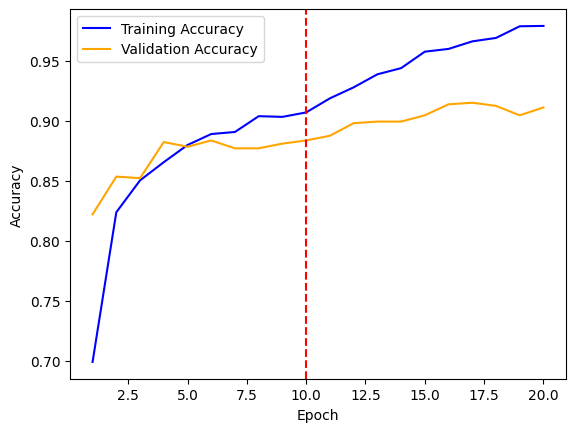

In [ ]:
# Visualize loss history
plt.plot(range(1, sum(epoch_counts) + 1), accuracy_phase_1+accuracy_phase_2, color='blue')
plt.plot(range(1, sum(epoch_counts) + 1), val_accuracy_phase_1+val_accuracy_phase_2, color='orange')
plt.axvline(x=epoch_counts[0], color='r', linestyle='--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

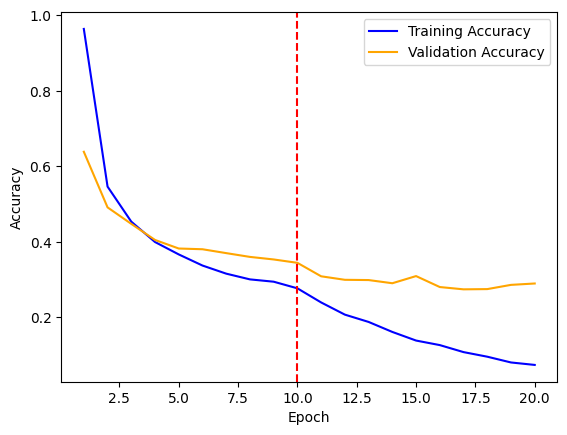

In [ ]:
# Visualize loss history
plt.plot(range(1, sum(epoch_counts) + 1), loss_phase_1+loss_phase_2, color='blue')
plt.plot(range(1, sum(epoch_counts) + 1), val_loss_phase_1+val_loss_phase_2, color='orange')
plt.axvline(x=epoch_counts[0], color='r', linestyle='--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

## MobileNetV2

In [ ]:
model_name = "MobileNetV2"

In [ ]:
base_model = keras.applications.MobileNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(image_size[0], image_size[1], 3),
    include_top=False,
    alpha=1.0
)  # Do not include the ImageNet classifier at the top.

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(image_size[0], image_size[1], 3))


# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(8, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "model_4"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_10 (InputLayer)       [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling_4 (Rescaling)     (None, 150, 150, 3)       0         Y          
                                                                            
 mobilenetv2_1.00_224 (Func  (None, 5, 5, 1280)        2257984   N          
 tional)                                                                    
                                                                            
 global_average_pooling2d_4  (None, 1280)              0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dropout_4 (Dropout)         (None, 1280)              0   

In [ ]:
model.compile(
    optimizer=phase_1_optimizer(),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

print("Fitting the top layer of the model")
model.fit(train_ds, epochs=epoch_counts[0], validation_data=validation_ds)


Fitting the top layer of the model
Epoch 1/10
110/110 [==============================] - 11s 68ms/step - loss: 0.9085 - accuracy: 0.6820 - val_loss: 0.5720 - val_accuracy: 0.7932
Epoch 2/10
110/110 [==============================] - 5s 42ms/step - loss: 0.5112 - accuracy: 0.8129 - val_loss: 0.4761 - val_accuracy: 0.8429
Epoch 3/10
110/110 [==============================] - 6s 55ms/step - loss: 0.4212 - accuracy: 0.8520 - val_loss: 0.4137 - val_accuracy: 0.8508
Epoch 4/10
110/110 [==============================] - 5s 42ms/step - loss: 0.3551 - accuracy: 0.8794 - val_loss: 0.4232 - val_accuracy: 0.8482
Epoch 5/10
110/110 [==============================] - 6s 57ms/step - loss: 0.3324 - accuracy: 0.8789 - val_loss: 0.4310 - val_accuracy: 0.8560
Epoch 6/10
110/110 [==============================] - 5s 42ms/step - loss: 0.3009 - accuracy: 0.8903 - val_loss: 0.3798 - val_accuracy: 0.8743
Epoch 7/10
110/110 [==============================] - 6s 55ms/step - loss: 0.2679 - accuracy: 0.9011 - val

In [ ]:
accuracy_phase_1 = model.history.history["accuracy"]
val_accuracy_phase_1 = model.history.history["val_accuracy"]

In [ ]:
loss_phase_1 = model.history.history["loss"]
val_loss_phase_1 = model.history.history["val_loss"]

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=phase_2_optimizer(),  # Low learning rate
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

print("Fitting the end-to-end model")
model.fit(train_ds, epochs=epoch_counts[1], validation_data=validation_ds)

Model: "model_4"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_10 (InputLayer)       [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling_4 (Rescaling)     (None, 150, 150, 3)       0         Y          
                                                                            
 mobilenetv2_1.00_224 (Func  (None, 5, 5, 1280)        2257984   Y          
 tional)                                                                    
                                                                            
 global_average_pooling2d_4  (None, 1280)              0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dropout_4 (Dropout)         (None, 1280)              0   

### Accuracy

In [ ]:
accuracy_phase_2 = model.history.history["accuracy"]
val_accuracy_phase_2 = model.history.history["val_accuracy"]

In [ ]:
loss_phase_2 = model.history.history["loss"]
val_loss_phase_2 = model.history.history["val_loss"]

In [ ]:
print("Test dataset evaluation")
model.evaluate(test_ds)

Test dataset evaluation
23/23 [==============================] - 1s 34ms/step - loss: 0.4024 - accuracy: 0.9022


[0.40238282084465027, 0.9021739363670349]

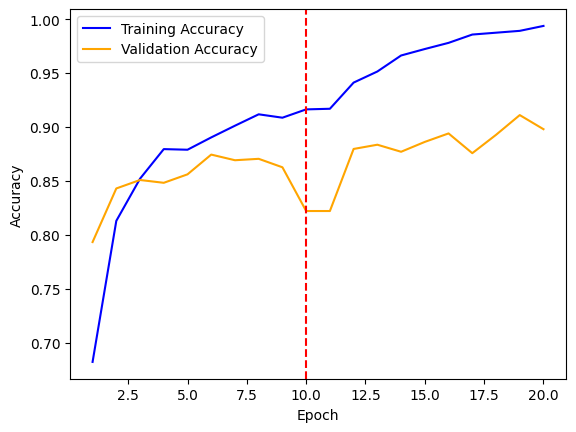

In [ ]:
# Visualize loss history
plt.plot(range(1, sum(epoch_counts) + 1), accuracy_phase_1+accuracy_phase_2, color='blue')
plt.plot(range(1, sum(epoch_counts) + 1), val_accuracy_phase_1+val_accuracy_phase_2, color='orange')
plt.axvline(x=epoch_counts[0], color='r', linestyle='--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

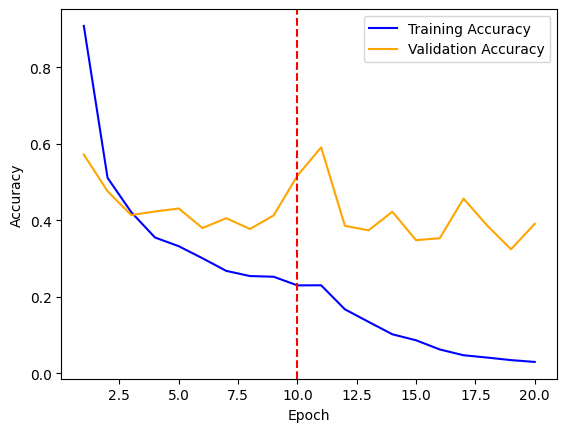

In [ ]:
# Visualize loss history
plt.plot(range(1, sum(epoch_counts) + 1), loss_phase_1+loss_phase_2, color='blue')
plt.plot(range(1, sum(epoch_counts) + 1), val_loss_phase_1+val_loss_phase_2, color='orange')
plt.axvline(x=epoch_counts[0], color='r', linestyle='--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

# Training Kather19

## VGG19

In [ ]:
model_name = "VGG19"

In [ ]:
base_model = keras.applications.VGG19(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(image_size[0], image_size[1], 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.


80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(image_size[0], image_size[1], 3))


# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(number_of_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 224, 224, 3)       0         Y          
                                                                            
 vgg19 (Functional)          (None, 7, 7, 512)         2002438   N          
                                                       4                    
                                                                            
 global_average_pooling2d (  (None, 512)               0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dropout (Dropout)           (None, 512)               0     

In [ ]:
checkpoint_filepath = f"{os.environ['DRIVE_DATA_DIR']}/training_results/intermediate-{model_name}-{os.environ['DATASET']}"+".{epoch:02d}-{val_loss:.2f}-phase-1.keras"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = False,
    save_weights_only = False,
    save_freq = "epoch")

cca. 1h 20 min for 10 epochs

In [ ]:
model.compile(
    optimizer=phase_1_optimizer(),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

print("Fitting the top layer of the model")
model.fit(train_ds, epochs=epoch_counts[0], validation_data=validation_ds, callbacks=[model_checkpoint_callback])

Fitting the top layer of the model
Epoch 1/10
2188/2188 [==============================] - ETA: 0s - loss: 0.6046 - accuracy: 0.8164
Epoch 1: saving model to ./gdrive/MyDrive/master-thesis/intermediate-VGG19-NCT-CRC-HE-100K.01-0.38-phase-1.keras
2188/2188 [==============================] - 487s 217ms/step - loss: 0.6046 - accuracy: 0.8164 - val_loss: 0.3779 - val_accuracy: 0.8781
Epoch 2/10
2188/2188 [==============================] - ETA: 0s - loss: 0.3833 - accuracy: 0.8695
Epoch 2: saving model to ./gdrive/MyDrive/master-thesis/intermediate-VGG19-NCT-CRC-HE-100K.02-0.32-phase-1.keras
2188/2188 [==============================] - 477s 218ms/step - loss: 0.3833 - accuracy: 0.8695 - val_loss: 0.3249 - val_accuracy: 0.8931
Epoch 3/10
2188/2188 [==============================] - ETA: 0s - loss: 0.3529 - accuracy: 0.8787
Epoch 3: saving model to ./gdrive/MyDrive/master-thesis/intermediate-VGG19-NCT-CRC-HE-100K.03-0.30-phase-1.keras
2188/2188 [==============================] - 470s 214ms/st

In [ ]:
accuracy_phase_1 = model.history.history["accuracy"]
val_accuracy_phase_1 = model.history.history["val_accuracy"]

In [ ]:
loss_phase_1 = model.history.history["loss"]
val_loss_phase_1 = model.history.history["val_loss"]

In [ ]:
train_info = accuracy_phase_1, val_accuracy_phase_1, loss_phase_1, val_loss_phase_1

with open(f"{os.environ['DRIVE_DATA_DIR']}/training_results/{model_name}-phase-1.pkl", 'wb') as file:
	pickle.dump(train_info, file)

In [ ]:
with open(f"{os.environ['DRIVE_DATA_DIR']}/training_results/{model_name}-phase-1.pkl", 'rb') as file:
  accuracy_phase_1, val_accuracy_phase_1, loss_phase_1, val_loss_phase_1 = pickle.load(file)

1 h 3 min 31 sec - 3 epochs

3 h 30 min - 10 epochs

In [ ]:
checkpoint_filepath = f"{os.environ['DRIVE_DATA_DIR']}/training_results/intermediate-{model_name}-{os.environ['DATASET']}"+".{epoch:02d}-{val_loss:.2f}-phase-2.keras"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = False,
    save_weights_only = False,
    save_freq = "epoch")

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=phase_2_optimizer(),  # Low learning rate
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

print("Fitting the end-to-end model")
model.fit(train_ds, epochs=epoch_counts[1], validation_data=validation_ds, callbacks=[model_checkpoint_callback])

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 224, 224, 3)       0         Y          
                                                                            
 vgg19 (Functional)          (None, 7, 7, 512)         2002438   Y          
                                                       4                    
                                                                            
 global_average_pooling2d (  (None, 512)               0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dropout (Dropout)           (None, 512)               0     

In [ ]:
model = keras.models.load_model(f"{os.environ['DRIVE_DATA_DIR']}/training_results/intermediate-{model_name}-{os.environ['DATASET']}.07-0.05-phase-2.keras")

In [ ]:
model.fit(train_ds, epochs=3, validation_data=validation_ds, callbacks=[model_checkpoint_callback])

Epoch 1/3
2188/2188 [==============================] - ETA: 0s - loss: 0.0407 - accuracy: 0.9886
Epoch 1: saving model to ./gdrive/MyDrive/master-thesis/intermediate-VGG19-NCT-CRC-HE-100K.01-0.06-phase-2.keras
2188/2188 [==============================] - 1218s 545ms/step - loss: 0.0407 - accuracy: 0.9886 - val_loss: 0.0593 - val_accuracy: 0.9854
Epoch 2/3
2188/2188 [==============================] - ETA: 0s - loss: 0.0441 - accuracy: 0.9884
Epoch 2: saving model to ./gdrive/MyDrive/master-thesis/intermediate-VGG19-NCT-CRC-HE-100K.02-0.09-phase-2.keras
2188/2188 [==============================] - 1186s 541ms/step - loss: 0.0441 - accuracy: 0.9884 - val_loss: 0.0929 - val_accuracy: 0.9745
Epoch 3/3
2188/2188 [==============================] - ETA: 0s - loss: 0.0507 - accuracy: 0.9889
Epoch 3: saving model to ./gdrive/MyDrive/master-thesis/intermediate-VGG19-NCT-CRC-HE-100K.03-1.38-phase-2.keras
2188/2188 [==============================] - 1187s 542ms/step - loss: 0.0507 - accuracy: 0.988

### Accuracy

In [ ]:
accuracy_phase_2 = [0.9505, 0.9773, 0.9839, 0.9866, 0.9882, 0.9889, 0.9889] + model.history.history["accuracy"]
val_accuracy_phase_2 = [0.9751, 0.9689, 0.9850, 0.9824, 0.9811, 0.9875, 0.9877] + model.history.history["val_accuracy"]
loss_phase_2 = [0.1521, 0.0737, 0.0528, 0.0444, 0.0409, 0.0373, 0.0405] + model.history.history["loss"]
val_loss_phase_2 = [0.0829, 0.0979, 0.0505, 0.0667, 0.0774, 0.0538, 0.0530] + model.history.history["val_loss"]

In [ ]:
print("Test dataset evaluation")
model.evaluate(test_ds)

Test dataset evaluation
469/469 [==============================] - 69s 147ms/step - loss: 1.3386 - accuracy: 0.9506


[1.3386014699935913, 0.950559675693512]

In [ ]:
# Visualize loss history
plt.plot(range(1, sum(epoch_counts) + 1), accuracy_phase_1+accuracy_phase_2, color='blue')
plt.plot(range(1, sum(epoch_counts) + 1), val_accuracy_phase_1+val_accuracy_phase_2, color='orange')
plt.axvline(x=epoch_counts[0], color='r', linestyle='--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

In [ ]:
# Visualize loss history
plt.plot(range(1, sum(epoch_counts) + 1), loss_phase_1+loss_phase_2, color='blue')
plt.plot(range(1, sum(epoch_counts) + 1), val_loss_phase_1+val_loss_phase_2, color='orange')
plt.axvline(x=epoch_counts[0], color='r', linestyle='--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

## EfficientNetV2B0

In [ ]:
model_name = "EfficientNetV2B0"

In [ ]:
base_model = keras.applications.EfficientNetV2B0(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(image_size[0], image_size[1], 3),
    include_top=False,
    include_preprocessing=False,
)  # Do not include the ImageNet classifier at the top.

In [ ]:
# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(image_size[0], image_size[1], 3))


# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(number_of_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "model_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         Y          
                                                                            
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         Y          
                                                                            
 efficientnetv2-b0 (Functio  (None, 7, 7, 1280)        5919312   N          
 nal)                                                                       
                                                                            
 global_average_pooling2d_1  (None, 1280)              0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dropout_1 (Dropout)         (None, 1280)              0   

In [ ]:
checkpoint_filepath = f"{os.environ['DRIVE_DATA_DIR']}/training_results/intermediate-{model_name}-{os.environ['DATASET']}"+".{epoch:02d}-{val_loss:.2f}-phase-1.keras"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = False,
    save_weights_only = False,
    save_freq = "epoch")

51 min 10 epochs

In [ ]:
model.compile(
    optimizer=phase_1_optimizer(),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

print("Fitting the top layer of the model")
model.fit(train_ds, epochs=epoch_counts[0], validation_data=validation_ds, callbacks=[model_checkpoint_callback])


Fitting the top layer of the model
Epoch 1/10
2187/2188 [============================>.] - ETA: 0s - loss: 0.2446 - accuracy: 0.9238
Epoch 1: saving model to ./gdrive/MyDrive/master-thesis/intermediate-EfficientNetV2B0-NCT-CRC-HE-100K.01-0.16-phase-1.keras
2188/2188 [==============================] - 302s 134ms/step - loss: 0.2445 - accuracy: 0.9238 - val_loss: 0.1575 - val_accuracy: 0.9512
Epoch 2/10
2188/2188 [==============================] - ETA: 0s - loss: 0.1492 - accuracy: 0.9517
Epoch 2: saving model to ./gdrive/MyDrive/master-thesis/intermediate-EfficientNetV2B0-NCT-CRC-HE-100K.02-0.14-phase-1.keras
2188/2188 [==============================] - 291s 133ms/step - loss: 0.1492 - accuracy: 0.9517 - val_loss: 0.1361 - val_accuracy: 0.9570
Epoch 3/10
2187/2188 [============================>.] - ETA: 0s - loss: 0.1335 - accuracy: 0.9564
Epoch 3: saving model to ./gdrive/MyDrive/master-thesis/intermediate-EfficientNetV2B0-NCT-CRC-HE-100K.03-0.12-phase-1.keras
2188/2188 [==============

In [ ]:
accuracy_phase_1 = model.history.history["accuracy"]
val_accuracy_phase_1 = model.history.history["val_accuracy"]

In [ ]:
loss_phase_1 = model.history.history["loss"]
val_loss_phase_1 = model.history.history["val_loss"]

In [ ]:
train_info = accuracy_phase_1, val_accuracy_phase_1, loss_phase_1, val_loss_phase_1

In [ ]:
with open(f"{os.environ['DRIVE_DATA_DIR']}/training_results/{model_name}-phase-1.pkl", 'wb') as file:
	pickle.dump(train_info, file)

In [ ]:
checkpoint_filepath = f"{os.environ['DRIVE_DATA_DIR']}/training_results/intermediate-{model_name}-{os.environ['DATASET']}"+".{epoch:02d}-{val_loss:.2f}-phase-2.keras"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = False,
    save_weights_only = False,
    save_freq = "epoch")

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=phase_2_optimizer(),  # Low learning rate
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

print("Fitting the end-to-end model")
model.fit(train_ds, epochs=epoch_counts[1], validation_data=validation_ds, callbacks=[model_checkpoint_callback])

Model: "model_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         Y          
                                                                            
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         Y          
                                                                            
 efficientnetv2-b0 (Functio  (None, 7, 7, 1280)        5919312   Y          
 nal)                                                                       
                                                                            
 global_average_pooling2d_1  (None, 1280)              0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dropout_1 (Dropout)         (None, 1280)              0   

### Accuracy

In [ ]:
accuracy_phase_2 = model.history.history["accuracy"]
val_accuracy_phase_2 = model.history.history["val_accuracy"]

In [ ]:
loss_phase_2 = model.history.history["loss"]
val_loss_phase_2 = model.history.history["val_loss"]

In [ ]:
print("Test dataset evaluation")
model.evaluate(test_ds)

Test dataset evaluation
469/469 [==============================] - 43s 91ms/step - loss: 0.0320 - accuracy: 0.9919


[0.03195648267865181, 0.9918709993362427]

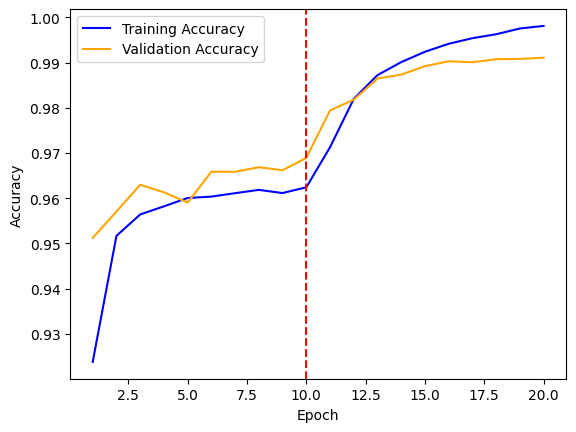

In [ ]:
# Visualize loss history
plt.plot(range(1, sum(epoch_counts) + 1), accuracy_phase_1+accuracy_phase_2, color='blue')
plt.plot(range(1, sum(epoch_counts) + 1), val_accuracy_phase_1+val_accuracy_phase_2, color='orange')
plt.axvline(x=epoch_counts[0], color='r', linestyle='--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

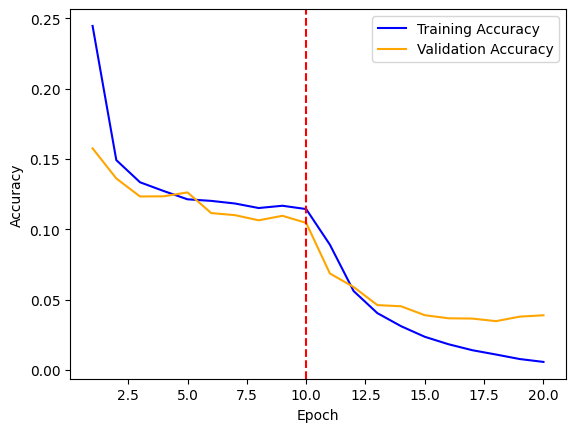

In [ ]:
# Visualize loss history
plt.plot(range(1, sum(epoch_counts) + 1), loss_phase_1+loss_phase_2, color='blue')
plt.plot(range(1, sum(epoch_counts) + 1), val_loss_phase_1+val_loss_phase_2, color='orange')
plt.axvline(x=epoch_counts[0], color='r', linestyle='--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

## MobileNetV2

In [ ]:
model_name = "MobileNetV2"

In [ ]:
base_model = keras.applications.MobileNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(image_size[0], image_size[1], 3),
    include_top=False,
    alpha=1.0
)  # Do not include the ImageNet classifier at the top.

9406464/9406464 [==============================] - 2s 0us/step


In [ ]:
# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(image_size[0], image_size[1], 3))


# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(number_of_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 224, 224, 3)       0         Y          
                                                                            
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   N          
 tional)                                                                    
                                                                            
 global_average_pooling2d (  (None, 1280)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dropout (Dropout)           (None, 1280)              0     

In [ ]:
checkpoint_filepath = f"{os.environ['DRIVE_DATA_DIR']}/training_results/intermediate-{model_name}-{os.environ['DATASET']}"+".{epoch:02d}-{val_loss:.2f}-phase-1.keras"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = False,
    save_weights_only = False,
    save_freq = "epoch")

In [ ]:
model.compile(
    optimizer=phase_1_optimizer(),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

print("Fitting the top layer of the model")
model.fit(train_ds, epochs=epoch_counts[0], validation_data=validation_ds, callbacks=[model_checkpoint_callback])


Fitting the top layer of the model
Epoch 1/10
2188/2188 [==============================] - ETA: 0s - loss: 0.2637 - accuracy: 0.9123
Epoch 1: saving model to ./gdrive/MyDrive/master-thesis/intermediate-MobileNetV2-NCT-CRC-HE-100K.01-0.18-phase-1.keras
2188/2188 [==============================] - 293s 130ms/step - loss: 0.2637 - accuracy: 0.9123 - val_loss: 0.1758 - val_accuracy: 0.9442
Epoch 2/10
2187/2188 [============================>.] - ETA: 0s - loss: 0.1899 - accuracy: 0.9379
Epoch 2: saving model to ./gdrive/MyDrive/master-thesis/intermediate-MobileNetV2-NCT-CRC-HE-100K.02-0.17-phase-1.keras
2188/2188 [==============================] - 282s 129ms/step - loss: 0.1899 - accuracy: 0.9379 - val_loss: 0.1714 - val_accuracy: 0.9440
Epoch 3/10
2187/2188 [============================>.] - ETA: 0s - loss: 0.1772 - accuracy: 0.9437
Epoch 3: saving model to ./gdrive/MyDrive/master-thesis/intermediate-MobileNetV2-NCT-CRC-HE-100K.03-0.16-phase-1.keras
2188/2188 [=============================

In [ ]:
accuracy_phase_1 = [0.9123, 0.9379, 0.9437, 0.9439, 0.9455, 0.9467, 0.9462, 0.9476, 0.9482, 0.9478]
val_accuracy_phase_1 = [0.9442, 0.9440, 0.9488, 0.9510, 0.9506, 0.9462, 0.9525, 0.9510, 0.9498, 0.9422]
loss_phase_1 = [0.2637, 0.1899, 0.1772, 0.1751, 0.1714, 0.1701, 0.1704, 0.1693, 0.1678, 0.1683]
val_loss_phase_1 = [0.1758, 0.1714, 0.1644, 0.1578, 0.1586, 0.1715, 0.1586, 0.1642, 0.1658, 0.1897]

In [ ]:
accuracy_phase_1 = model.history.history["accuracy"]
val_accuracy_phase_1 = model.history.history["val_accuracy"]

In [ ]:
loss_phase_1 = model.history.history["loss"]
val_loss_phase_1 = model.history.history["val_loss"]

In [ ]:
checkpoint_filepath = f"{os.environ['DRIVE_DATA_DIR']}/training_results/intermediate-{model_name}-{os.environ['DATASET']}"+".{epoch:02d}-{val_loss:.2f}-phase-2.keras"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = False,
    save_weights_only = False,
    save_freq = "epoch")

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=phase_2_optimizer(),  # Low learning rate
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

print("Fitting the end-to-end model")
model.fit(train_ds, epochs=epoch_counts[1], validation_data=validation_ds, callbacks=[model_checkpoint_callback])

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 224, 224, 3)       0         Y          
                                                                            
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   Y          
 tional)                                                                    
                                                                            
 global_average_pooling2d (  (None, 1280)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dropout (Dropout)           (None, 1280)              0     

In [ ]:
model = keras.models.load_model(f"{os.environ['DRIVE_DATA_DIR']}/training_results/intermediate-{model_name}-{os.environ['DATASET']}.02-0.07-phase-2.keras")

In [ ]:
print("Fitting the end-to-end model")
model.fit(train_ds, epochs=8, validation_data=validation_ds, callbacks=[model_checkpoint_callback])

Fitting the end-to-end model
Epoch 1/8
2188/2188 [==============================] - ETA: 0s - loss: 0.0535 - accuracy: 0.9830
Epoch 1: saving model to ./gdrive/MyDrive/master-thesis/intermediate-MobileNetV2-NCT-CRC-HE-100K.01-0.06-phase-2.keras
2188/2188 [==============================] - 448s 190ms/step - loss: 0.0535 - accuracy: 0.9830 - val_loss: 0.0606 - val_accuracy: 0.9829
Epoch 2/8
2188/2188 [==============================] - ETA: 0s - loss: 0.0393 - accuracy: 0.9870
Epoch 2: saving model to ./gdrive/MyDrive/master-thesis/intermediate-MobileNetV2-NCT-CRC-HE-100K.02-0.07-phase-2.keras
2188/2188 [==============================] - 400s 182ms/step - loss: 0.0393 - accuracy: 0.9870 - val_loss: 0.0706 - val_accuracy: 0.9764
Epoch 3/8
2188/2188 [==============================] - ETA: 0s - loss: 0.0290 - accuracy: 0.9904
Epoch 3: saving model to ./gdrive/MyDrive/master-thesis/intermediate-MobileNetV2-NCT-CRC-HE-100K.03-0.05-phase-2.keras
2188/2188 [==============================] - 406s

### Accuracy

In [ ]:
accuracy_phase_2 = [0.9572, 0.9750] + model.history.history["accuracy"]
val_accuracy_phase_2 = [0.9691, 0.9789] + model.history.history["val_accuracy"]

loss_phase_2 = [0.1350, 0.0780] + model.history.history["loss"]
val_loss_phase_2 = [0.0985, 0.0683] + model.history.history["val_loss"]

In [ ]:
print("Test dataset evaluation")
model.evaluate(test_ds)

Test dataset evaluation
469/469 [==============================] - 34s 71ms/step - loss: 0.0457 - accuracy: 0.9895


[0.04571840912103653, 0.9894722700119019]

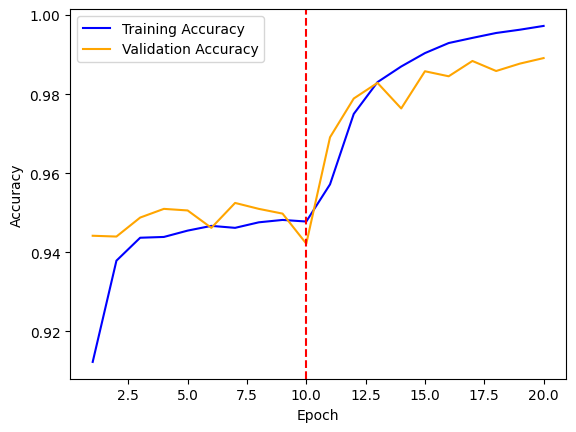

In [ ]:
# Visualize loss history
plt.plot(range(1, sum(epoch_counts) + 1), accuracy_phase_1+accuracy_phase_2, color='blue')
plt.plot(range(1, sum(epoch_counts) + 1), val_accuracy_phase_1+val_accuracy_phase_2, color='orange')
plt.axvline(x=epoch_counts[0], color='r', linestyle='--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

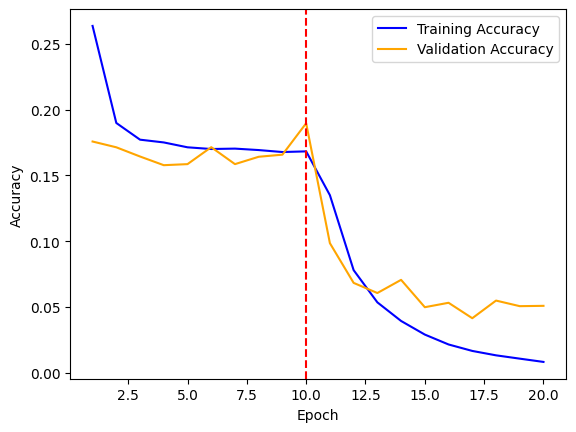

In [ ]:
# Visualize loss history
plt.plot(range(1, sum(epoch_counts) + 1), loss_phase_1+loss_phase_2, color='blue')
plt.plot(range(1, sum(epoch_counts) + 1), val_loss_phase_1+val_loss_phase_2, color='orange')
plt.axvline(x=epoch_counts[0], color='r', linestyle='--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

# Training Merged dataset - k16 NONORM

## VGG19

In [ ]:
model_name = "VGG19"

In [ ]:
base_model = keras.applications.VGG19(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(image_size[0], image_size[1], 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.


80134624/80134624 [==============================] - 4s 0us/step


In [ ]:
# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(image_size[0], image_size[1], 3))


# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(number_of_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "model_2"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_6 (InputLayer)        [(None, 100, 100, 3)]     0         Y          
                                                                            
 rescaling_2 (Rescaling)     (None, 100, 100, 3)       0         Y          
                                                                            
 vgg19 (Functional)          (None, 3, 3, 512)         2002438   N          
                                                       4                    
                                                                            
 global_average_pooling2d_2  (None, 512)               0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dropout_2 (Dropout)         (None, 512)               0   

In [ ]:
checkpoint_filepath = f"{os.environ['DRIVE_DATA_DIR']}/training_results/intermediate-{model_name}-{os.environ['DATASET']}"+".{epoch:02d}-{val_loss:.2f}-phase-1.keras"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = False,
    save_weights_only = False,
    save_freq = "epoch")

In [ ]:
model.compile(
    optimizer=phase_1_optimizer(),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

print("Fitting the top layer of the model")
model.fit(train_ds, epochs=epoch_counts[0], validation_data=validation_ds, callbacks=[model_checkpoint_callback])

Fitting the top layer of the model
Epoch 1/10
2427/2427 [==============================] - ETA: 0s - loss: 0.6613 - accuracy: 0.7838
Epoch 1: saving model to ./gdrive/MyDrive/master-thesis/training_results/intermediate-VGG19-merged_datasets.01-0.47-phase-1.keras
2427/2427 [==============================] - 133s 54ms/step - loss: 0.6613 - accuracy: 0.7838 - val_loss: 0.4685 - val_accuracy: 0.8439
Epoch 2/10
2427/2427 [==============================] - ETA: 0s - loss: 0.4980 - accuracy: 0.8276
Epoch 2: saving model to ./gdrive/MyDrive/master-thesis/training_results/intermediate-VGG19-merged_datasets.02-0.43-phase-1.keras
2427/2427 [==============================] - 125s 51ms/step - loss: 0.4980 - accuracy: 0.8276 - val_loss: 0.4287 - val_accuracy: 0.8581
Epoch 3/10
2427/2427 [==============================] - ETA: 0s - loss: 0.4748 - accuracy: 0.8360
Epoch 3: saving model to ./gdrive/MyDrive/master-thesis/training_results/intermediate-VGG19-merged_datasets.03-0.41-phase-1.keras
2427/2427

In [ ]:
# accuracy_phase_1 = model.history.history["accuracy"]
# val_accuracy_phase_1 = model.history.history["val_accuracy"]
# loss_phase_1 = model.history.history["loss"]
# val_loss_phase_1 = model.history.history["val_loss"]

accuracy_phase_1 = [0.7838, 0.8276, 0.8360, 0.8409, 0.8435, 0.8451, 0.8468, 0.8471, 0.8482, 0.8496]
val_accuracy_phase_1 = [0.8439, 0.8581, 0.8630, 0.8660, 0.8685, 0.8705, 0.8712, 0.8705, 0.8722, 0.8729]

loss_phase_1 = [0.6613, 0.4980, 0.4748, 0.4601, 0.4553, 0.4486, 0.4468, 0.4452, 0.4403, 0.4386]
val_loss_phase_1 = [0.4685, 0.4287, 0.4092, 0.3979, 0.3909, 0.3874, 0.3834, 0.3805, 0.3788, 0.3771]

In [ ]:
checkpoint_filepath = f"{os.environ['DRIVE_DATA_DIR']}/training_results/intermediate-{model_name}-{os.environ['DATASET']}"+".{epoch:02d}-{val_loss:.2f}-phase-2.keras"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = False,
    save_weights_only = False,
    save_freq = "epoch")

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=phase_2_optimizer(),  # Low learning rate
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

print("Fitting the end-to-end model")
model.fit(train_ds, epochs=epoch_counts[1], validation_data=validation_ds, callbacks=[model_checkpoint_callback])

Model: "model_2"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_6 (InputLayer)        [(None, 100, 100, 3)]     0         Y          
                                                                            
 rescaling_2 (Rescaling)     (None, 100, 100, 3)       0         Y          
                                                                            
 vgg19 (Functional)          (None, 3, 3, 512)         2002438   Y          
                                                       4                    
                                                                            
 global_average_pooling2d_2  (None, 512)               0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dropout_2 (Dropout)         (None, 512)               0   

In [ ]:
accuracy_phase_2_1 = [0.9228, 0.9612, 0.9730, 0.9779, 0.9818, 0.9839, 0.9844, 0.9843]
val_accuracy_phase_2_1 = [0.9472, 0.9706, 0.9737, 0.9716, 0.9769, 0.9796, 0.9764, 0.9641]

loss_phase_2_1 = [0.1530, 0.0918, 0.0865, 0.1069, 0.0875, 0.0774, 0.0928, 0.1345]
val_loss_phase_2_1 = [0.2340, 0.1186, 0.0841, 0.0673, 0.0571, 0.0557, 0.0530, 0.0548]

In [ ]:
model = keras.models.load_model(f"{os.environ['DRIVE_DATA_DIR']}/training_results/intermediate-{model_name}-{os.environ['DATASET']}.08-0.13-phase-2.keras")

In [ ]:
model.fit(train_ds, epochs=2, validation_data=validation_ds, callbacks=[model_checkpoint_callback])

Epoch 1/2
2427/2427 [==============================] - ETA: 0s - loss: 0.0575 - accuracy: 0.9844
Epoch 1: saving model to ./gdrive/MyDrive/master-thesis/training_results/intermediate-VGG19-merged_datasets.01-0.13-phase-2.keras
2427/2427 [==============================] - 347s 139ms/step - loss: 0.0575 - accuracy: 0.9844 - val_loss: 0.1308 - val_accuracy: 0.9749
Epoch 2/2
2427/2427 [==============================] - ETA: 0s - loss: 0.0647 - accuracy: 0.9834
Epoch 2: saving model to ./gdrive/MyDrive/master-thesis/training_results/intermediate-VGG19-merged_datasets.02-0.07-phase-2.keras
2427/2427 [==============================] - 346s 142ms/step - loss: 0.0647 - accuracy: 0.9834 - val_loss: 0.0740 - val_accuracy: 0.9797


### Accuracy

In [ ]:
accuracy_phase_2 = accuracy_phase_2_1 + model.history.history["accuracy"]
val_accuracy_phase_2 = val_accuracy_phase_2_1 + model.history.history["val_accuracy"]
loss_phase_2 = loss_phase_2_1 + model.history.history["loss"]
val_loss_phase_2 = val_loss_phase_2_1 + model.history.history["val_loss"]

In [ ]:
print("Test dataset evaluation")
model.evaluate(test_ds)

Test dataset evaluation
520/520 [==============================] - 21s 40ms/step - loss: 0.0806 - accuracy: 0.9795


[0.08057192713022232, 0.9795072078704834]

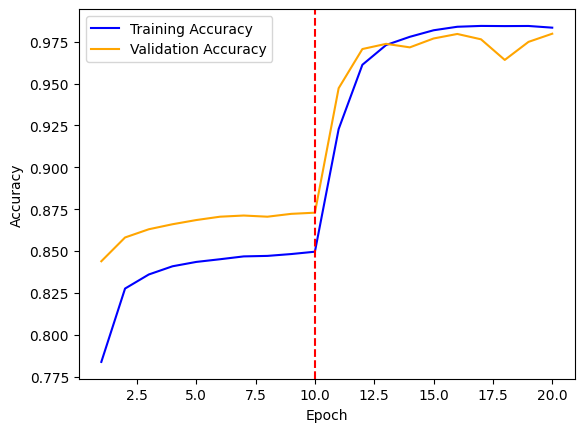

In [ ]:
# Visualize loss history
plt.plot(range(1, sum(epoch_counts) + 1), accuracy_phase_1+accuracy_phase_2, color='blue')
plt.plot(range(1, sum(epoch_counts) + 1), val_accuracy_phase_1+val_accuracy_phase_2, color='orange')
plt.axvline(x=epoch_counts[0], color='r', linestyle='--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

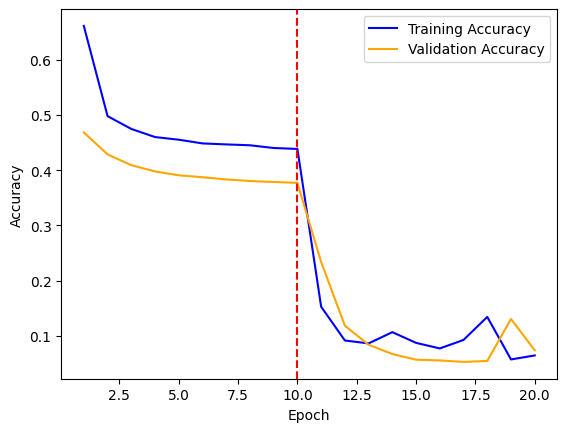

In [ ]:
# Visualize loss history
plt.plot(range(1, sum(epoch_counts) + 1), loss_phase_1+loss_phase_2, color='blue')
plt.plot(range(1, sum(epoch_counts) + 1), val_loss_phase_1+val_loss_phase_2, color='orange')
plt.axvline(x=epoch_counts[0], color='r', linestyle='--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

## MobileNetV2

In [ ]:
model_name = "MobileNetV2"

In [ ]:
base_model = keras.applications.MobileNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(image_size[0], image_size[1], 3),
    include_top=False,
    alpha=1.0
)  # Do not include the ImageNet classifier at the top.

9406464/9406464 [==============================] - 2s 0us/step


In [ ]:
# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(image_size[0], image_size[1], 3))


# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(number_of_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 100, 100, 3)       0         Y          
                                                                            
 mobilenetv2_1.00_224 (Func  (None, 4, 4, 1280)        2257984   N          
 tional)                                                                    
                                                                            
 global_average_pooling2d (  (None, 1280)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dropout (Dropout)           (None, 1280)              0     

In [ ]:
checkpoint_filepath = f"{os.environ['DRIVE_DATA_DIR']}/training_results/intermediate-{model_name}-{os.environ['DATASET']}"+".{epoch:02d}-{val_loss:.2f}-phase-1.keras"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = False,
    save_weights_only = False,
    save_freq = "epoch")

In [ ]:
model.compile(
    optimizer=phase_1_optimizer(),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

print("Fitting the top layer of the model")
model.fit(train_ds, epochs=epoch_counts[0], validation_data=validation_ds, callbacks=[model_checkpoint_callback])


Fitting the top layer of the model
Epoch 1/10
2427/2427 [==============================] - ETA: 0s - loss: 0.4481 - accuracy: 0.8553
Epoch 1: saving model to ./gdrive/MyDrive/master-thesis/training_results/intermediate-MobileNetV2-merged_datasets.01-0.35-phase-1.keras
2427/2427 [==============================] - 123s 48ms/step - loss: 0.4481 - accuracy: 0.8553 - val_loss: 0.3533 - val_accuracy: 0.8845
Epoch 2/10
2425/2427 [============================>.] - ETA: 0s - loss: 0.3640 - accuracy: 0.8839
Epoch 2: saving model to ./gdrive/MyDrive/master-thesis/training_results/intermediate-MobileNetV2-merged_datasets.02-0.30-phase-1.keras
2427/2427 [==============================] - 129s 53ms/step - loss: 0.3639 - accuracy: 0.8839 - val_loss: 0.3046 - val_accuracy: 0.9070
Epoch 3/10
2424/2427 [============================>.] - ETA: 0s - loss: 0.3587 - accuracy: 0.8869
Epoch 3: saving model to ./gdrive/MyDrive/master-thesis/training_results/intermediate-MobileNetV2-merged_datasets.03-0.33-phase

In [ ]:
accuracy_phase_1 = model.history.history["accuracy"]
val_accuracy_phase_1 = model.history.history["val_accuracy"]

In [ ]:
loss_phase_1 = model.history.history["loss"]
val_loss_phase_1 = model.history.history["val_loss"]

In [ ]:
checkpoint_filepath = f"{os.environ['DRIVE_DATA_DIR']}/training_results/intermediate-{model_name}-{os.environ['DATASET']}"+".{epoch:02d}-{val_loss:.2f}-phase-2.keras"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = False,
    save_weights_only = False,
    save_freq = "epoch")

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=phase_2_optimizer(),  # Low learning rate
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

print("Fitting the end-to-end model")
model.fit(train_ds, epochs=epoch_counts[1], validation_data=validation_ds, callbacks=[model_checkpoint_callback])

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 100, 100, 3)       0         Y          
                                                                            
 mobilenetv2_1.00_224 (Func  (None, 4, 4, 1280)        2257984   Y          
 tional)                                                                    
                                                                            
 global_average_pooling2d (  (None, 1280)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dropout (Dropout)           (None, 1280)              0     

### Accuracy

In [ ]:
accuracy_phase_2 = model.history.history["accuracy"]
val_accuracy_phase_2 = model.history.history["val_accuracy"]

loss_phase_2 = model.history.history["loss"]
val_loss_phase_2 = model.history.history["val_loss"]

In [ ]:
print("Test dataset evaluation")
model.evaluate(test_ds)

Test dataset evaluation
520/520 [==============================] - 13s 26ms/step - loss: 0.1035 - accuracy: 0.9769


[0.10351080447435379, 0.9768629670143127]

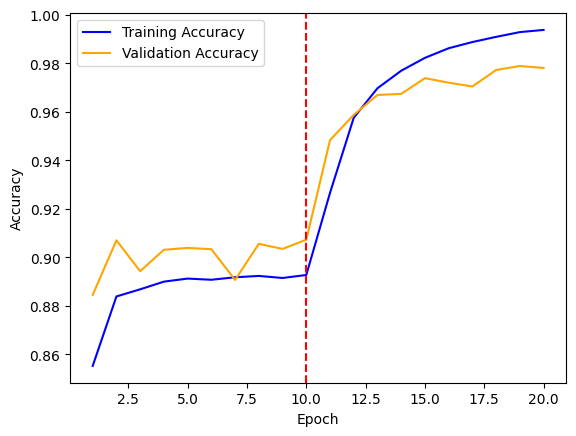

In [ ]:
# Visualize loss history
plt.plot(range(1, sum(epoch_counts) + 1), accuracy_phase_1+accuracy_phase_2, color='blue')
plt.plot(range(1, sum(epoch_counts) + 1), val_accuracy_phase_1+val_accuracy_phase_2, color='orange')
plt.axvline(x=epoch_counts[0], color='r', linestyle='--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

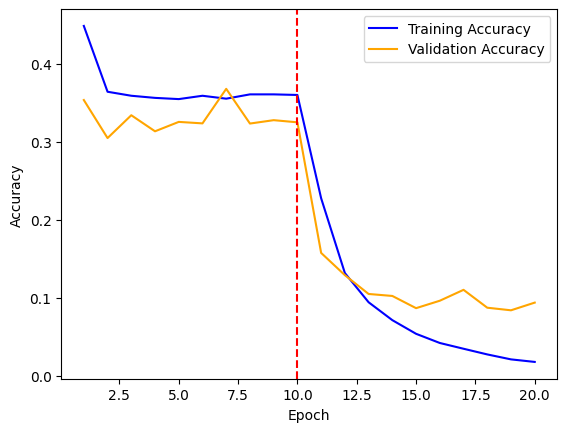

In [ ]:
# Visualize loss history
plt.plot(range(1, sum(epoch_counts) + 1), loss_phase_1+loss_phase_2, color='blue')
plt.plot(range(1, sum(epoch_counts) + 1), val_loss_phase_1+val_loss_phase_2, color='orange')
plt.axvline(x=epoch_counts[0], color='r', linestyle='--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

## EfficientNetV2B0

In [ ]:
model_name = "EfficientNetV2B0"

In [ ]:
base_model = keras.applications.EfficientNetV2B0(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(image_size[0], image_size[1], 3),
    include_top=False,
    include_preprocessing=False,
)  # Do not include the ImageNet classifier at the top.

24274472/24274472 [==============================] - 2s 0us/step


In [ ]:
# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(image_size[0], image_size[1], 3))


# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(number_of_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "model_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_4 (InputLayer)        [(None, 100, 100, 3)]     0         Y          
                                                                            
 rescaling_1 (Rescaling)     (None, 100, 100, 3)       0         Y          
                                                                            
 efficientnetv2-b0 (Functio  (None, 4, 4, 1280)        5919312   N          
 nal)                                                                       
                                                                            
 global_average_pooling2d_1  (None, 1280)              0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dropout_1 (Dropout)         (None, 1280)              0   

In [ ]:
checkpoint_filepath = f"{os.environ['DRIVE_DATA_DIR']}/training_results/intermediate-{model_name}-{os.environ['DATASET']}"+".{epoch:02d}-{val_loss:.2f}-phase-1.keras"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = False,
    save_weights_only = False,
    save_freq = "epoch")

In [ ]:
model.compile(
    optimizer=phase_1_optimizer(),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

print("Fitting the top layer of the model")
model.fit(train_ds, epochs=epoch_counts[0], validation_data=validation_ds, callbacks=[model_checkpoint_callback])


Fitting the top layer of the model
Epoch 1/10
2427/2427 [==============================] - ETA: 0s - loss: 0.4173 - accuracy: 0.8652
Epoch 1: saving model to ./gdrive/MyDrive/master-thesis/training_results/intermediate-EfficientNetV2B0-merged_datasets.01-0.30-phase-1.keras
2427/2427 [==============================] - 109s 42ms/step - loss: 0.4173 - accuracy: 0.8652 - val_loss: 0.3025 - val_accuracy: 0.8985
Epoch 2/10
2427/2427 [==============================] - ETA: 0s - loss: 0.3067 - accuracy: 0.8972
Epoch 2: saving model to ./gdrive/MyDrive/master-thesis/training_results/intermediate-EfficientNetV2B0-merged_datasets.02-0.27-phase-1.keras
2427/2427 [==============================] - 90s 37ms/step - loss: 0.3067 - accuracy: 0.8972 - val_loss: 0.2675 - val_accuracy: 0.9115
Epoch 3/10
2426/2427 [============================>.] - ETA: 0s - loss: 0.2875 - accuracy: 0.9039
Epoch 3: saving model to ./gdrive/MyDrive/master-thesis/training_results/intermediate-EfficientNetV2B0-merged_datasets

In [ ]:
accuracy_phase_1 = model.history.history["accuracy"]
val_accuracy_phase_1 = model.history.history["val_accuracy"]

In [ ]:
loss_phase_1 = model.history.history["loss"]
val_loss_phase_1 = model.history.history["val_loss"]

In [ ]:
checkpoint_filepath = f"{os.environ['DRIVE_DATA_DIR']}/training_results/intermediate-{model_name}-{os.environ['DATASET']}"+".{epoch:02d}-{val_loss:.2f}-phase-2.keras"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = False,
    save_weights_only = False,
    save_freq = "epoch")

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=phase_2_optimizer(),  # Low learning rate
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

print("Fitting the end-to-end model")
model.fit(train_ds, epochs=epoch_counts[1], validation_data=validation_ds, callbacks=[model_checkpoint_callback])

Model: "model_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_4 (InputLayer)        [(None, 100, 100, 3)]     0         Y          
                                                                            
 rescaling_1 (Rescaling)     (None, 100, 100, 3)       0         Y          
                                                                            
 efficientnetv2-b0 (Functio  (None, 4, 4, 1280)        5919312   Y          
 nal)                                                                       
                                                                            
 global_average_pooling2d_1  (None, 1280)              0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dropout_1 (Dropout)         (None, 1280)              0   

### Accuracy

In [ ]:
accuracy_phase_2 = model.history.history["accuracy"]
val_accuracy_phase_2 = model.history.history["val_accuracy"]

In [ ]:
loss_phase_2 = model.history.history["loss"]
val_loss_phase_2 = model.history.history["val_loss"]

In [ ]:
print("Test dataset evaluation")
model.evaluate(test_ds)

Test dataset evaluation
520/520 [==============================] - 14s 26ms/step - loss: 0.0994 - accuracy: 0.9770


[0.09941484034061432, 0.9770432710647583]

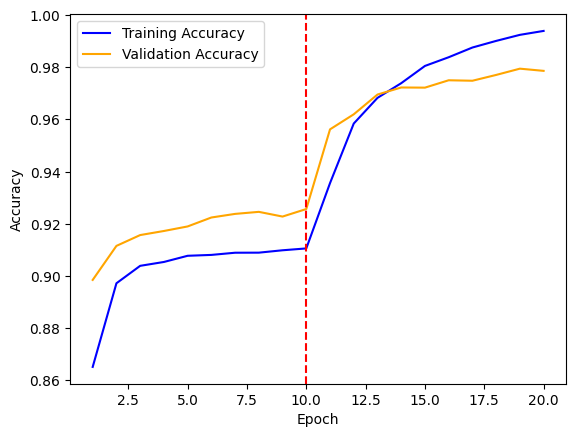

In [ ]:
# Visualize loss history
plt.plot(range(1, sum(epoch_counts) + 1), accuracy_phase_1+accuracy_phase_2, color='blue')
plt.plot(range(1, sum(epoch_counts) + 1), val_accuracy_phase_1+val_accuracy_phase_2, color='orange')
plt.axvline(x=epoch_counts[0], color='r', linestyle='--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

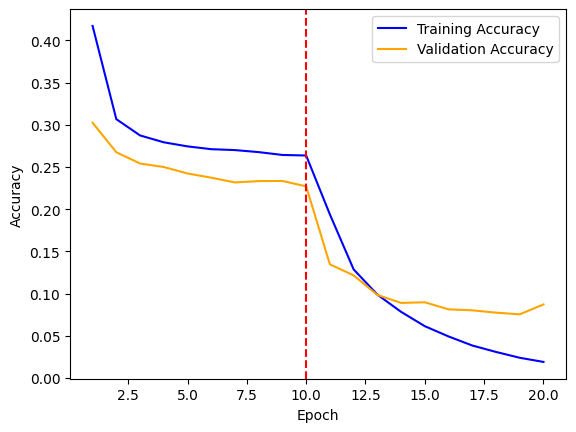

In [ ]:
# Visualize loss history
plt.plot(range(1, sum(epoch_counts) + 1), loss_phase_1+loss_phase_2, color='blue')
plt.plot(range(1, sum(epoch_counts) + 1), val_loss_phase_1+val_loss_phase_2, color='orange')
plt.axvline(x=epoch_counts[0], color='r', linestyle='--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

# Training Merged dataset - k16 NORM

## VGG19

In [ ]:
model_name = "VGG19"

In [ ]:
base_model = keras.applications.VGG19(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(image_size[0], image_size[1], 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.


80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(image_size[0], image_size[1], 3))


# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(number_of_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 100, 100, 3)       0         Y          
                                                                            
 vgg19 (Functional)          (None, 3, 3, 512)         2002438   N          
                                                       4                    
                                                                            
 global_average_pooling2d (  (None, 512)               0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dropout (Dropout)           (None, 512)               0     

In [ ]:
checkpoint_filepath = f"{os.environ['DRIVE_DATA_DIR']}/training_results/intermediate-{model_name}-{os.environ['DATASET']}"+".{epoch:02d}-{val_loss:.2f}-phase-1.keras"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = False,
    save_weights_only = False,
    save_freq = "epoch")

In [ ]:
model.compile(
    optimizer=phase_1_optimizer(),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

print("Fitting the top layer of the model")
model.fit(train_ds, epochs=epoch_counts[0], validation_data=validation_ds, callbacks=[model_checkpoint_callback])

Fitting the top layer of the model
Epoch 1/10
2427/2427 [==============================] - ETA: 0s - loss: 0.6605 - accuracy: 0.7840
Epoch 1: saving model to ./gdrive/MyDrive/master-thesis/training_results/intermediate-VGG19-merged_datasets_k16-NORM.01-0.47-phase-1.keras
2427/2427 [==============================] - 137s 54ms/step - loss: 0.6605 - accuracy: 0.7840 - val_loss: 0.4709 - val_accuracy: 0.8452
Epoch 2/10
2427/2427 [==============================] - ETA: 0s - loss: 0.5016 - accuracy: 0.8288
Epoch 2: saving model to ./gdrive/MyDrive/master-thesis/training_results/intermediate-VGG19-merged_datasets_k16-NORM.02-0.43-phase-1.keras
2427/2427 [==============================] - 136s 56ms/step - loss: 0.5016 - accuracy: 0.8288 - val_loss: 0.4328 - val_accuracy: 0.8553
Epoch 3/10
2427/2427 [==============================] - ETA: 0s - loss: 0.4797 - accuracy: 0.8350
Epoch 3: saving model to ./gdrive/MyDrive/master-thesis/training_results/intermediate-VGG19-merged_datasets_k16-NORM.03-0

In [ ]:
accuracy_phase_1 = [0.7840, 0.8288, 0.8350, 0.8391, 0.8406, 0.8437, 0.8440, 0.8442, 0.8464, 0.8470]
val_accuracy_phase_1 = [0.8452, 0.8553, 0.8628, 0.8647, 0.8668, 0.8659, 0.8701, 0.8696, 0.8710, 0.8711]

loss_phase_1 = [0.6605, 0.5016, 0.4797, 0.4686, 0.4605, 0.4579, 0.4538, 0.4536, 0.4491, 0.4498]
val_loss_phase_1 = [0.4709, 0.4328, 0.4151, 0.4061, 0.3996, 0.3974, 0.3922, 0.3896, 0.3890, 0.3863]

In [ ]:
checkpoint_filepath = f"{os.environ['DRIVE_DATA_DIR']}/training_results/intermediate-{model_name}-{os.environ['DATASET']}"+".{epoch:02d}-{val_loss:.2f}-phase-2.keras"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = False,
    save_weights_only = False,
    save_freq = "epoch")

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=phase_2_optimizer(),  # Low learning rate
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

print("Fitting the end-to-end model")
model.fit(train_ds, epochs=epoch_counts[1], validation_data=validation_ds, callbacks=[model_checkpoint_callback])

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 100, 100, 3)       0         Y          
                                                                            
 vgg19 (Functional)          (None, 3, 3, 512)         2002438   Y          
                                                       4                    
                                                                            
 global_average_pooling2d (  (None, 512)               0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dropout (Dropout)           (None, 512)               0     

In [ ]:
accuracy_phase_2 = [0.9143, 0.9568, 0.9688, 0.9747, 0.9785, 0.9800, 0.9810, 0.9808, 0.9791, 0.9778]
val_accuracy_phase_2 = [0.9534, 0.9603, 0.9690, 0.9623, 0.9724, 0.9687, 0.9741, 0.9761, 0.9685, 0.9711]

loss_phase_2= [0.2572, 0.1347, 0.0984, 0.0788, 0.0696, 0.0660, 0.0681, 0.0693, 0.0733, 0.0804]
val_loss_phase_2 = [0.1447, 0.1297, 0.0968, 0.1213, 0.1147, 0.1122, 0.1024, 0.0919, 0.1653, 0.1162]

In [ ]:
model = keras.models.load_model(f"{os.environ['DRIVE_DATA_DIR']}/training_results/intermediate-{model_name}-{os.environ['DATASET']}.10-0.12-phase-2.keras")

### Accuracy

In [ ]:
print("Test dataset evaluation")
model.evaluate(test_ds)

Test dataset evaluation
520/520 [==============================] - 22s 41ms/step - loss: 0.1250 - accuracy: 0.9674


[0.1249704360961914, 0.9674279093742371]

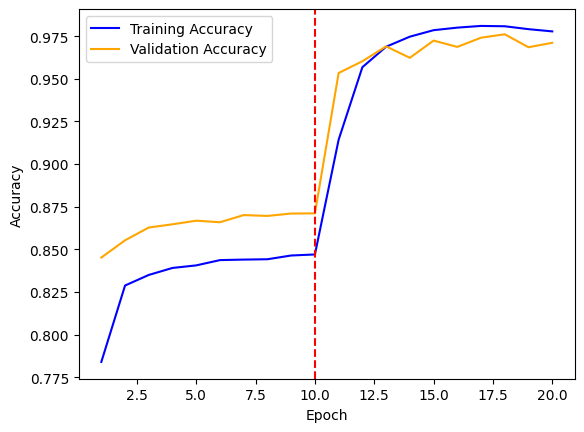

In [ ]:
# Visualize loss history
plt.plot(range(1, sum(epoch_counts) + 1), accuracy_phase_1+accuracy_phase_2, color='blue')
plt.plot(range(1, sum(epoch_counts) + 1), val_accuracy_phase_1+val_accuracy_phase_2, color='orange')
plt.axvline(x=epoch_counts[0], color='r', linestyle='--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

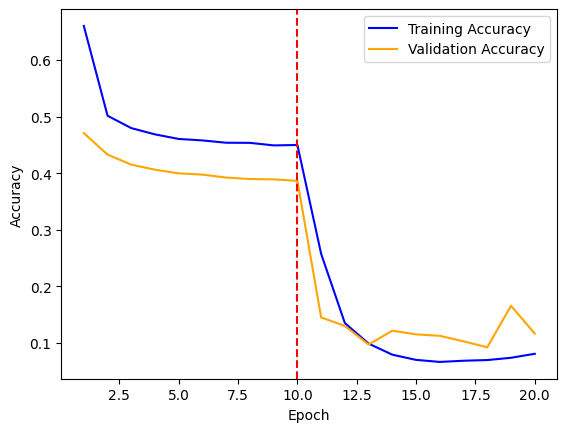

In [ ]:
# Visualize loss history
plt.plot(range(1, sum(epoch_counts) + 1), loss_phase_1+loss_phase_2, color='blue')
plt.plot(range(1, sum(epoch_counts) + 1), val_loss_phase_1+val_loss_phase_2, color='orange')
plt.axvline(x=epoch_counts[0], color='r', linestyle='--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

## MobileNetV2

In [ ]:
model_name = "MobileNetV2"

In [ ]:
base_model = keras.applications.MobileNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(image_size[0], image_size[1], 3),
    include_top=False,
    alpha=1.0
)  # Do not include the ImageNet classifier at the top.

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(image_size[0], image_size[1], 3))


# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(number_of_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 100, 100, 3)       0         Y          
                                                                            
 mobilenetv2_1.00_224 (Func  (None, 4, 4, 1280)        2257984   N          
 tional)                                                                    
                                                                            
 global_average_pooling2d (  (None, 1280)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dropout (Dropout)           (None, 1280)              0     

In [ ]:
model.compile(
    optimizer=phase_1_optimizer(),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

print("Fitting the top layer of the model")
model.fit(train_ds, epochs=epoch_counts[0], validation_data=validation_ds)

Fitting the top layer of the model
Epoch 1/10
2427/2427 [==============================] - 92s 35ms/step - loss: 0.4561 - accuracy: 0.8525 - val_loss: 0.3462 - val_accuracy: 0.8891
Epoch 2/10
2427/2427 [==============================] - 85s 35ms/step - loss: 0.3748 - accuracy: 0.8818 - val_loss: 0.3107 - val_accuracy: 0.9052
Epoch 3/10
2427/2427 [==============================] - 77s 32ms/step - loss: 0.3674 - accuracy: 0.8843 - val_loss: 0.3476 - val_accuracy: 0.8918
Epoch 4/10
2427/2427 [==============================] - 75s 31ms/step - loss: 0.3629 - accuracy: 0.8889 - val_loss: 0.3500 - val_accuracy: 0.8942
Epoch 5/10
2427/2427 [==============================] - 78s 32ms/step - loss: 0.3623 - accuracy: 0.8891 - val_loss: 0.3395 - val_accuracy: 0.8996
Epoch 6/10
2427/2427 [==============================] - 78s 32ms/step - loss: 0.3673 - accuracy: 0.8889 - val_loss: 0.3462 - val_accuracy: 0.8998
Epoch 7/10
2427/2427 [==============================] - 78s 32ms/step - loss: 0.3679 - ac

In [ ]:
accuracy_phase_1 = model.history.history["accuracy"]
val_accuracy_phase_1 = model.history.history["val_accuracy"]

In [ ]:
loss_phase_1 = model.history.history["loss"]
val_loss_phase_1 = model.history.history["val_loss"]

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=phase_2_optimizer(),  # Low learning rate
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

print("Fitting the end-to-end model")
model.fit(train_ds, epochs=epoch_counts[1], validation_data=validation_ds)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 100, 100, 3)       0         Y          
                                                                            
 mobilenetv2_1.00_224 (Func  (None, 4, 4, 1280)        2257984   Y          
 tional)                                                                    
                                                                            
 global_average_pooling2d (  (None, 1280)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dropout (Dropout)           (None, 1280)              0     

### Accuracy

In [ ]:
accuracy_phase_2 = model.history.history["accuracy"]
val_accuracy_phase_2 = model.history.history["val_accuracy"]

loss_phase_2 = model.history.history["loss"]
val_loss_phase_2 = model.history.history["val_loss"]

In [ ]:
print("Test dataset evaluation")
model.evaluate(test_ds)

Test dataset evaluation
520/520 [==============================] - 11s 21ms/step - loss: 0.1316 - accuracy: 0.9707


[0.13157136738300323, 0.9706730842590332]

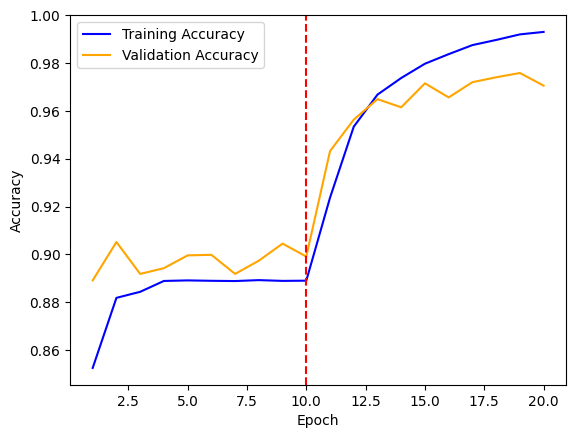

In [ ]:
# Visualize loss history
plt.plot(range(1, sum(epoch_counts) + 1), accuracy_phase_1+accuracy_phase_2, color='blue')
plt.plot(range(1, sum(epoch_counts) + 1), val_accuracy_phase_1+val_accuracy_phase_2, color='orange')
plt.axvline(x=epoch_counts[0], color='r', linestyle='--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

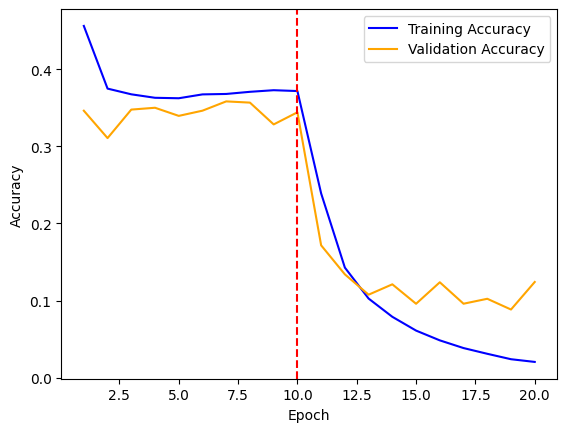

In [ ]:
# Visualize loss history
plt.plot(range(1, sum(epoch_counts) + 1), loss_phase_1+loss_phase_2, color='blue')
plt.plot(range(1, sum(epoch_counts) + 1), val_loss_phase_1+val_loss_phase_2, color='orange')
plt.axvline(x=epoch_counts[0], color='r', linestyle='--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

## EfficientNetV2B0

In [ ]:
model_name = "EfficientNetV2B0"

In [ ]:
base_model = keras.applications.EfficientNetV2B0(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(image_size[0], image_size[1], 3),
    include_top=False,
    include_preprocessing=False,
)  # Do not include the ImageNet classifier at the top.

24274472/24274472 [==============================] - 0s 0us/step


In [ ]:
# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(image_size[0], image_size[1], 3))


# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(number_of_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "model_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_4 (InputLayer)        [(None, 100, 100, 3)]     0         Y          
                                                                            
 rescaling_1 (Rescaling)     (None, 100, 100, 3)       0         Y          
                                                                            
 efficientnetv2-b0 (Functio  (None, 4, 4, 1280)        5919312   N          
 nal)                                                                       
                                                                            
 global_average_pooling2d_1  (None, 1280)              0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dropout_1 (Dropout)         (None, 1280)              0   

In [ ]:
model.compile(
    optimizer=phase_1_optimizer(),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

print("Fitting the top layer of the model")
model.fit(train_ds, epochs=epoch_counts[0], validation_data=validation_ds)


Fitting the top layer of the model
Epoch 1/10
2427/2427 [==============================] - 109s 41ms/step - loss: 0.4237 - accuracy: 0.8637 - val_loss: 0.3102 - val_accuracy: 0.8973
Epoch 2/10
2427/2427 [==============================] - 89s 36ms/step - loss: 0.3155 - accuracy: 0.8947 - val_loss: 0.2737 - val_accuracy: 0.9117
Epoch 3/10
2427/2427 [==============================] - 85s 35ms/step - loss: 0.2998 - accuracy: 0.8995 - val_loss: 0.2713 - val_accuracy: 0.9098
Epoch 4/10
2427/2427 [==============================] - 86s 36ms/step - loss: 0.2911 - accuracy: 0.9019 - val_loss: 0.2602 - val_accuracy: 0.9133
Epoch 5/10
2427/2427 [==============================] - 92s 38ms/step - loss: 0.2854 - accuracy: 0.9041 - val_loss: 0.2511 - val_accuracy: 0.9170
Epoch 6/10
2427/2427 [==============================] - 114s 47ms/step - loss: 0.2841 - accuracy: 0.9039 - val_loss: 0.2515 - val_accuracy: 0.9183
Epoch 7/10
2427/2427 [==============================] - 96s 40ms/step - loss: 0.2821 - 

In [ ]:
accuracy_phase_1 = model.history.history["accuracy"]
val_accuracy_phase_1 = model.history.history["val_accuracy"]

In [ ]:
loss_phase_1 = model.history.history["loss"]
val_loss_phase_1 = model.history.history["val_loss"]

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=phase_2_optimizer(),  # Low learning rate
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy'],
)

print("Fitting the end-to-end model")
model.fit(train_ds, epochs=epoch_counts[1], validation_data=validation_ds)

Model: "model_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_4 (InputLayer)        [(None, 100, 100, 3)]     0         Y          
                                                                            
 rescaling_1 (Rescaling)     (None, 100, 100, 3)       0         Y          
                                                                            
 efficientnetv2-b0 (Functio  (None, 4, 4, 1280)        5919312   Y          
 nal)                                                                       
                                                                            
 global_average_pooling2d_1  (None, 1280)              0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dropout_1 (Dropout)         (None, 1280)              0   

### Accuracy

In [ ]:
accuracy_phase_2 = model.history.history["accuracy"]
val_accuracy_phase_2 = model.history.history["val_accuracy"]

In [ ]:
loss_phase_2 = model.history.history["loss"]
val_loss_phase_2 = model.history.history["val_loss"]

In [ ]:
print("Test dataset evaluation")
model.evaluate(test_ds)

Test dataset evaluation
520/520 [==============================] - 16s 30ms/step - loss: 0.1085 - accuracy: 0.9736


[0.10851709544658661, 0.9736177921295166]

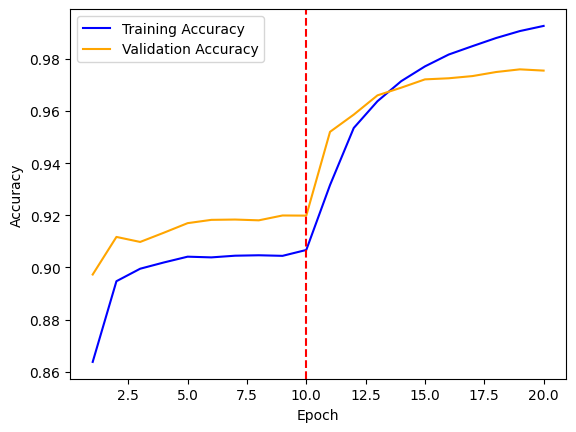

In [ ]:
# Visualize loss history
plt.plot(range(1, sum(epoch_counts) + 1), accuracy_phase_1+accuracy_phase_2, color='blue')
plt.plot(range(1, sum(epoch_counts) + 1), val_accuracy_phase_1+val_accuracy_phase_2, color='orange')
plt.axvline(x=epoch_counts[0], color='r', linestyle='--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

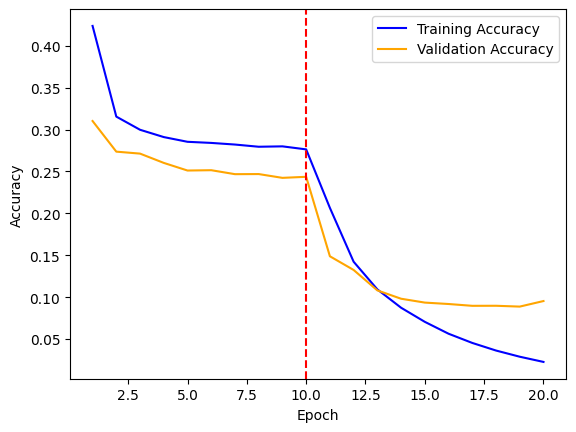

In [ ]:
# Visualize loss history
plt.plot(range(1, sum(epoch_counts) + 1), loss_phase_1+loss_phase_2, color='blue')
plt.plot(range(1, sum(epoch_counts) + 1), val_loss_phase_1+val_loss_phase_2, color='orange')
plt.axvline(x=epoch_counts[0], color='r', linestyle='--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

# Saving

In [ ]:
print(f"""
Model name: {model_name}
Dataset: {os.environ['DATASET']}
Image format: {os.environ['IMAGE_FORMAT']}
Image dimensions: {image_size[0]}x{image_size[1]}
Batch size: {batch_size}
Phase 1 optimizer: {phase1optimizer}
Phase 2 optimizer: {phase2optimizer}
      """)


Model name: EfficientNetV2B0
Dataset: merged_datasets_k16-NORM
Image format: png
Image dimensions: 100x100
Batch size: 32
Phase 1 optimizer: RMSprop
Phase 2 optimizer: RMSprop
      


In [ ]:
metrics = [
    {"accuracy": accuracy_phase_1, "val_accuracy": val_accuracy_phase_1, "loss": loss_phase_1, "val_loss": val_loss_phase_1},
     {"accuracy": accuracy_phase_2, "val_accuracy": val_accuracy_phase_2, "loss": loss_phase_2, "val_loss": val_loss_phase_2}
    ]

train_info = metrics, seed

In [ ]:
# Open a file and use dump()
with open(f"{os.environ['DRIVE_DATA_DIR']}/training_results/{os.environ['DATASET']}/{model_name}-{os.environ['DATASET']}-{os.environ['IMAGE_FORMAT']}-{image_size[0]}x{image_size[1]}-{batch_size}-{phase1optimizer}+{phase2optimizer}-70:15:15.pkl", 'wb') as file:

	# A new file will be created
	pickle.dump(train_info, file)


In [ ]:
model.save(f"{os.environ['DRIVE_DATA_DIR']}/training_results/{os.environ['DATASET']}/{model_name}-{os.environ['DATASET']}-{os.environ['IMAGE_FORMAT']}-{image_size[0]}x{image_size[1]}-{batch_size}-{phase1optimizer}+{phase2optimizer}-70:15:15.keras")